In [56]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.base import BaseEstimator, ClassifierMixin
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions import Normal
import os, sys
sys.path.append(os.path.join("/home/ra43rid/torch_plnet"))
torch.set_default_device("cuda")
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


class TorchMultivariateGaussianClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, class_params=None, device="cpu"):
        """
        Initialize the classifier with class parameters.

        Parameters:
        class_params: dict
            A dictionary where keys are class labels and values are dictionaries with
            'mean' (vector), 'cov' (matrix), and 'prior' for each class.
        device: str
            The device to use for computations ('cpu' or 'cuda').
        """
        self.class_params = class_params if class_params is not None else {}
        self.device = torch.device(device)
        self.classes_ = torch.tensor(list(self.class_params.keys()), device=self.device)
        self.n_features = len(self.class_params[0]["cov"])
        self.n_classes = len(self.classes_)
    
    def fit(self, X, y=None):
        """
        Fit method for compatibility. This classifier doesn't require fitting.
        """
        self.classes_ = torch.tensor(list(self.class_params.keys()), device=self.device)
        return self
    
    def predict_proba(self, X):
        """
        Predict the probability of each class for the given input data X.

        Parameters:
        X: torch.Tensor or array-like of shape (n_samples, n_features)
            Input features.

        Returns:
        probs: torch.Tensor of shape (n_samples, n_classes)
            Predicted probabilities for each class.
        """
        if not isinstance(X, torch.Tensor):
            X = torch.tensor(X, device=self.device, dtype=torch.float32)
        
        probs = torch.zeros((X.shape[0], len(self.classes_)), device=self.device)
        for i, c in enumerate(self.classes_):
            mean = torch.tensor(self.class_params[int(c)]["mean"], device=self.device, dtype=torch.float32)
            cov = torch.tensor(self.class_params[int(c)]["cov"], device=self.device, dtype=torch.float32)
            prior = self.class_params[int(c)]["prior"]
            
            # Multivariate normal distribution
            mvn_dist = MultivariateNormal(mean, covariance_matrix=cov)
            px_given_y = torch.exp(mvn_dist.log_prob(X))
            
            # Combine with prior
            probs[:, i] = px_given_y * prior
        
        # Normalize to get P(y=c|x)
        probs /= probs.sum(dim=1, keepdim=True)
        return probs
    
    def predict(self, X):
        """
        Predict the class label for each sample in X.

        Parameters:
        X: torch.Tensor or array-like of shape (n_samples, n_features)
            Input features.

        Returns:
        predictions: torch.Tensor of shape (n_samples,)
            Predicted class labels.
        """
        probs = self.predict_proba(X)
        return self.classes_[torch.argmax(probs, dim=1)]
    
    def generate_data(self, n_samples=100, seed=42):
        """
        Generate synthetic data using the predefined class parameters.

        Parameters:
        n_samples: int
            Number of samples to generate.

        Returns:
        X: torch.Tensor of shape (n_samples, n_features)
            Generated features.
        y: torch.Tensor of shape (n_samples,)
            Generated labels.
        """
        X = []
        y = []

        torch.manual_seed(seed) 
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

        for _ in range(n_samples):
            # Sample class based on priors
            sampled_class = torch.multinomial(
                torch.tensor([self.class_params[int(c)]["prior"] for c in self.classes_], device=self.device),
                num_samples=1
            ).item()
            mean = torch.tensor(self.class_params[int(self.classes_[sampled_class])]["mean"], device=self.device, dtype=torch.float32)
            cov = torch.tensor(self.class_params[int(self.classes_[sampled_class])]["cov"], device=self.device, dtype=torch.float32)
            
            # Sample feature vector from the corresponding multivariate Gaussian
            mvn_dist = MultivariateNormal(mean, covariance_matrix=cov)
            sampled_x = mvn_dist.sample()
            X.append(sampled_x)
            y.append(self.classes_[sampled_class].item())
        
        return torch.stack(X), torch.tensor(y, device=self.device)

class TorchGaussianSyntheticClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, class_params=None, device="cpu"):
        """
        Initialize the classifier with class parameters.

        Parameters:
        class_params: dict
            A dictionary where keys are class labels and values are dictionaries with
            'mean', 'std', and 'prior' for each class.
        device: str
            The device to use for computations ('cpu' or 'cuda').
        """
        self.class_params = class_params if class_params is not None else {}
        self.device = torch.device(device)
        self.classes_ = torch.tensor(list(self.class_params.keys()), device=self.device)
        self.n_features = 1
        self.n_classes = len(self.classes_)
    
    def fit(self, X, y=None):
        """
        Fit method for compatibility. This classifier doesn't require fitting.
        """
        self.classes_ = torch.tensor(list(self.class_params.keys()), device=self.device)
        return self
    
    def predict_proba(self, X):
        """
        Predict the probability of each class for the given input data X.

        Parameters:
        X: torch.Tensor or array-like of shape (n_samples,)
            Input features.

        Returns:
        probs: torch.Tensor of shape (n_samples, n_classes)
            Predicted probabilities for each class.
        """
        if not isinstance(X, torch.Tensor):
            X = torch.tensor(X, device=self.device, dtype=torch.float32)
        
        probs = torch.zeros((len(X), len(self.classes_)), device=self.device)
        for i, c in enumerate(self.classes_):
            mean = self.class_params[int(c)]["mean"]
            std = self.class_params[int(c)]["std"]
            prior = self.class_params[int(c)]["prior"]
            
            # Calculate Gaussian PDF: P(x|y=c)
            normal_dist = Normal(loc=mean, scale=std)
            px_given_y = torch.exp(normal_dist.log_prob(X))
            
            # Combine with prior: P(x|y=c) * P(y=c)
            probs[:, i] = px_given_y * prior
        
        # Normalize to get P(y=c|x)
        probs /= probs.sum(dim=1, keepdim=True)
        return probs
    
    def predict(self, X):
        """
        Predict the class label for each sample in X.

        Parameters:
        X: torch.Tensor or array-like of shape (n_samples,)
            Input features.

        Returns:
        predictions: torch.Tensor of shape (n_samples,)
            Predicted class labels.
        """
        probs = self.predict_proba(X)
        return self.classes_[torch.argmax(probs, dim=1)]

    def generate_data(self, n_samples=100, seed=42):
        """
        Generate synthetic data using the predefined class parameters.

        Parameters:
        n_samples: int
            Number of samples to generate.

        Returns:
        X: torch.Tensor of shape (n_samples,)
            Generated features.
        y: torch.Tensor of shape (n_samples,)
            Generated labels.
        """


        torch.manual_seed(seed) 
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)


        X = []
        y = []
        for _ in range(n_samples):
            # Sample class based on priors
            sampled_class = torch.multinomial(
                torch.tensor([self.class_params[int(c)]["prior"] for c in self.classes_], device=self.device),
                num_samples=1
            ).item()
            # Sample feature value from the corresponding Gaussian
            mean = self.class_params[int(self.classes_[sampled_class])]["mean"]
            std = self.class_params[int(self.classes_[sampled_class])]["std"]
            normal_dist = Normal(loc=mean, scale=std)
            sampled_x = normal_dist.sample().item()
            X.append(sampled_x)
            y.append(self.classes_[sampled_class].item())
        
        return torch.tensor(X, device=self.device), torch.tensor(y, device=self.device)

def goodman_kruskal_gamma(x, y):
    """
    Compute Goodman and Kruskal's Gamma for two ordinal variables.
    
    Parameters:
    x, y: Lists or arrays of ordinal data (same length)
    
    Returns:
    gamma: Goodman and Kruskal's Gamma
    """
    if len(x) != len(y):
        raise ValueError("Both variables must have the same length.")
    
    concordant = 0
    discordant = 0
    
    n = len(x)
    for i in range(n - 1):
        for j in range(i + 1, n):
            # Determine concordance or discordance
            if (x[i] > x[j] and y[i] > y[j]) or (x[i] < x[j] and y[i] < y[j]):
                concordant += 1
            elif (x[i] > x[j] and y[i] < y[j]) or (x[i] < x[j] and y[i] > y[j]):
                discordant += 1
    
    # Compute Gamma
    if concordant + discordant == 0:
        return 0  # Avoid division by zero
    gamma = (concordant - discordant) / (concordant + discordant)
    return gamma

from torchcp.classification.score import APS, THR, SAPS
aps = APS(score_type="identity", randomized=False)
rand_aps = APS(score_type="identity", randomized=True)
lac = THR(score_type="identity",)
saps = SAPS(score_type="identity",randomized=False)

class_params_1f_2c = {
    0: {"mean": 1, "std": 1, "prior": 0.3},
    1: {"mean": 3, "std": 1, "prior": 0.4},
    # 2: {"mean": 4, "std": 2.2, "prior": 0.3},
}   

class_params_1f_3c = {
    0: {"mean": 1, "std": 1, "prior": 0.3},
    1: {"mean": 3, "std": 1, "prior": 0.4},
    2: {"mean": 4, "std": 2.2, "prior": 0.3},
}   

# Initialize and fit the generator
class_params_2d_3c = {
    0: {
        "mean": [2.5, 2.0],  # Mean vector for class 0
        "cov": [
            [1.0, 0.5],
            [0.5, 1.2],
            # [0.3, 0.4, 0.8]
        ],  # Covariance matrix for class 0
        "prior": 0.3  # Prior probability for class 0
    },
    1: {
        "mean": [3.5, 4.0],  # Mean vector for class 1
        "cov": [
            [1.5, 0.3],
            [0.3, 1.1],
            # [0.2, 0.1, 0.9]
        ],  # Covariance matrix for class 1
        "prior": 0.4  # Prior probability for class 1
    },
    2: {
        "mean": [2.0, 1.0],  # Mean vector for class 2
        "cov": [
            [1.2, 0.4],
            [0.4, 1.3],
            # [0.3, 0.5, 1.4]
        ],  # Covariance matrix for class 2
        "prior": 0.3  # Prior probability for class 2
    },
}

# Initialize and fit the generator
class_params_3d_3c = {
    0: {
        "mean": [2.0, 2.0, 1.0],  # Mean vector for class 0
        "cov": [
            [1.0, 0.5, 0.3],
            [0.5, 1.2, 0.4],
            [0.3, 0.4, 0.8]
        ],  # Covariance matrix for class 0
        "prior": 1/3  # Prior probability for class 0
    },
    1: {
        "mean": [3.0, 4.0, 3.0],  # Mean vector for class 1
        "cov": [
            [1.5, 0.3, 0.2],
            [0.3, 1.1, 0.1],
            [0.2, 0.1, 0.9]
        ],  # Covariance matrix for class 1
        "prior": 1/3  # Prior probability for class 1
    },
    2: {
        "mean": [1.0, 2.0, 4.0],  # Mean vector for class 2
        "cov": [
            [1.2, 0.4, 0.3],
            [0.4, 1.3, 0.5],
            [0.3, 0.5, 1.4]
        ],  # Covariance matrix for class 2
        "prior": 1/3  # Prior probability for class 2
    },
}


# Initialize and fit the generator
class_params_2d_2c = {
    0: {
        "mean": [3.0, 2.0],  # Mean vector for class 0
        "cov": [
            [1.0, 0.5],
            [0.5, 1.2],
        ],  # Covariance matrix for class 0
        "prior": 0.3  # Prior probability for class 0
    },
    1: {
        "mean": [2.0, 3.0],  # Mean vector for class 1
        "cov": [
            [1.5, 0.3],
            [0.3, 1.1],
        ],  # Covariance matrix for class 1
        "prior": 0.4  # Prior probability for class 1
    },
    # 2: {
    #     "mean": [1.0, 2.0, 2.0],  # Mean vector for class 2
    #     "cov": [
    #         [1.2, 0.4],
    #         [0.4, 1.3],
    #         # [0.3, 0.5, 1.4]
    #     ],  # Covariance matrix for class 2
    #     "prior": 0.3  # Prior probability for class 2
    # },
}

gen_1d_2c = TorchGaussianSyntheticClassifier(class_params=class_params_1f_2c, device="cuda")
gen_1d_3c = TorchGaussianSyntheticClassifier(class_params=class_params_1f_3c, device="cuda")
gen_3d_3c = TorchMultivariateGaussianClassifier(class_params=class_params_3d_3c, device="cuda")
gen_2d_2c = TorchMultivariateGaussianClassifier(class_params=class_params_2d_2c, device="cuda")
gen_2d_3c = TorchMultivariateGaussianClassifier(class_params=class_params_2d_3c, device="cuda")

In [57]:
class OracleAnnotator:
    def __init__(self,score, generator):
        self.score = score
        self.classes_ = generator.classes_
        self.generator = generator

    # we assume y is already label encoded
    def get_conformity(self, X, y):
        y_pred_proba = self.generator.predict_proba(X)
        scores = self.score(y_pred_proba, y)
        return scores

In [58]:
from zmq import device
from util.ranking_datasets import LabelPairDataset
from models.ranking_models import LabelRankingModel
from torch.utils.data.dataloader import DataLoader
from scipy.stats import kendalltau
import matplotlib.pyplot as plt
import torch
from scipy.stats import kendalltau
from joblib import Parallel, delayed
torch.set_default_device("cuda")
import hashlib

def derive_seed(seed, index):
    combined = f"{seed}-{index}".encode()
    return int(hashlib.sha256(combined).hexdigest(), 16) % (2**32)



In [59]:
gen = gen_3d_3c
seeds = list(range(0,5))


In [60]:
def create_from_classification_data(X, y, num_classes):
    X_pairs = []
    y_pairs = []

    for X_vec, label in zip(X, y):
        for k in range(0, num_classes):
            if k == label:
                continue
            X_pairs.append(
                torch.vstack(
                    [
                        torch.tensor(X_vec, dtype=torch.float32),
                        torch.tensor(X_vec, dtype=torch.float32),
                    ]
                )
            )
            y_pairs.append(
                torch.vstack(
                    [
                        torch.tensor(label, dtype=torch.long),
                        torch.tensor(k, dtype=torch.long),
                    ]
                )
            )

    X_pairs = torch.stack(X_pairs)
    y_pairs = torch.stack(y_pairs)
    return X_pairs, y_pairs


def generate_bt_preferences_batch(gen, X,y, use_bt = True):

    probs = gen.predict_proba(X)
    prob_tensor = torch.take_along_dim(probs, y.unsqueeze(-1), dim=1).squeeze()
    assert prob_tensor.dim() == 1 and prob_tensor.size(0) % 2 == 0, "Input must be 1D tensor of even length"



    pairs = prob_tensor.view(-1, 2)
    s1 = pairs[:, 0]
    s2 = pairs[:, 1]

    if use_bt:
        prob_1_pref = torch.sigmoid(s1 - s2)
        preferences = torch.bernoulli(prob_1_pref)
    else:
        preferences = s1 > s2
    
    X_pairs = X.view(-1, 2, X.size(1))      # (N/2, 2, D)
    y_pairs = y.view(-1, 2)                 # (N/2, 2)
    prob_pairs = probs.view(-1, 2)          # (N/2, 2)

    # Bradley-Terry preference: probability first is preferred
    prob_1_pref = torch.sigmoid(prob_pairs[:, 0] - prob_pairs[:, 1])
    # Reorder both features and labels

    preferred_X = torch.where(preferences.unsqueeze(-1), X_pairs[:, 0], X_pairs[:, 1])
    nonpreferred_X = torch.where(preferences.unsqueeze(-1), X_pairs[:, 1], X_pairs[:, 0])
    paired_X = torch.stack([preferred_X, nonpreferred_X], dim=1)  # (N/2, 2, D)

    preferred_y = torch.where(preferences, y_pairs[:, 0], y_pairs[:, 1])
    nonpreferred_y = torch.where(preferences, y_pairs[:, 1], y_pairs[:, 0])
    paired_y = torch.stack([preferred_y, nonpreferred_y], dim=1)  # (N/2, 2)
    return paired_X, paired_y.unsqueeze(-1)

In [61]:
from models.classifier_model import ClassifierModel
from util.ranking_datasets import TabularDataset
def fit_classifier(X_train, y_train, X_es, y_es):

    model = ClassifierModel(
        input_dim=X_train.shape[1], hidden_dims=[5], output_dim=3
    )
    # model.cuda()
    # model.fit(
    #     X_train.cpu().detach().numpy(),
    #     y_train.cpu().detach().numpy(),
    #     num_epochs=500,
    #     patience=16,
    #     batch_size=32,
    #     val_frac=0.0,
    #     learning_rate=0.01,
    # )

    ds = TabularDataset(X_train, y_train)
    train_loader = DataLoader(ds, batch_size=32)
    ds_es = TabularDataset(X_es, y_es)
    es_loader = DataLoader(ds_es, batch_size=32)
    model._fit(
        train_loader=train_loader,
        val_loader=es_loader,
        num_epochs=500,
        patience=16,
        learning_rate=0.01,
        # verbose=True
    )


    return model

In [62]:
from models.ranking_models import LabelRankingModel
def fit_ranker(X_train, y_train, X_pairs=None, y_pairs=None, X_es = None, y_es=None):

    model = LabelRankingModel(
        input_dim=X_train.shape[1], hidden_dims=[5], output_dim=3
    )
    model.cuda()

    X_train_prf, y_train_prf = create_from_classification_data(X_train, y_train, 3)

    X_train_overall = torch.concat([X_train_prf, X_pairs])
    y_train_overall = torch.concat([y_train_prf, y_pairs])


    print(len(y_train_prf),len(y_train), len(y_train_overall))
    ds = LabelPairDataset()
    ds.create_from_numpy_pairs(X_train_overall, y_train_overall)
    pair_loader = DataLoader(ds, batch_size=32)
    X_es_pairs, y_es_pairs = create_from_classification_data(X_es, y_es, 3)
    ds_es = LabelPairDataset()
    ds_es.create_from_numpy_pairs(X_es_pairs, y_es_pairs)

    es_loader = DataLoader(ds_es, batch_size=32)
    model._fit(
        train_loader=pair_loader,
        val_loader=es_loader,
        num_epochs=500,
        patience=16,
        learning_rate=0.01,
        verbose=True
    )

    return model

In [ ]:
from itertools import product
from sklearn.metrics import accuracy_score
from torchcp.classification.score import APS, THR, TOPK, RAPS, SAPS, Margin, KNN
from conformal.conformal import IDENTITY, OWN_APS
from torchcp.classification.predictor import SplitPredictor
from torchcp.classification import Metrics
from itertools import product
from util.ranking_datasets import TabularDataset, LabelPairDataset


nums_clf_data = [10,20,30,40,50,100,150]
# nums_clf_data = [25,50,75,100]
master_seeds = list(range(20))
num_prf_data = 100
num_test_data = 100
num_calib_data = 100
num_es_data = 100

results = []

for master_seed, num_clf_data in product(master_seeds, nums_clf_data):

    X_calib, y_calib = gen.generate_data(num_calib_data, seed=derive_seed(master_seed,1))
    # two times the number because we want num_prf_data preferences
    X_prf, y_prf = gen.generate_data(2*num_prf_data, seed=derive_seed(master_seed,2))
    X_pairs, y_pairs = generate_bt_preferences_batch(gen, X_prf, y_prf, False)

    X_clf, y_clf = gen.generate_data(num_clf_data, seed=derive_seed(master_seed,3))

    X_test, y_test = gen.generate_data(num_test_data, seed=derive_seed(master_seed,4))

    X_es, y_es = gen.generate_data(num_es_data, seed=derive_seed(master_seed,5))

    ranker = fit_ranker(X_clf, y_clf, X_pairs, y_pairs, X_es, y_es)
    classifier = fit_classifier(X_clf, y_clf, X_es, y_es)

    ranker.num_classes = 3

    test_dataset = TabularDataset(X_test, y_test)
    test_loader = DataLoader(test_dataset, batch_size=32)

    # Classifier

    names = ["rand_aps", "aps", "thr"]
    alphas = [0.02,0.05,0.1,0.2]

    conformity_scores = [
        APS(randomized=True),
        APS(randomized=False),
        THR()
    ]
    for (name, conformity_score), alpha in product(
        zip(names, conformity_scores), alphas
    ):
        predictor = SplitPredictor(conformity_score, classifier)

        gradient_updates = predictor._model.gradient_updates

        cal_dataset = TabularDataset(X_calib, y_calib)

        cal_loader = DataLoader(cal_dataset,batch_size=32)

        predictor.calibrate(cal_loader, alpha)

        predictions_sets_list = []
        predictions_list = []
        labels_list = []
        logits_list = []
        feature_list = []

        # Evaluate in inference mode
        predictor._model.eval()
        with torch.no_grad():
            for batch in test_loader:
                # Move batch to device and get predictions
                inputs = batch[0]
                labels = batch[1]

                batch_predictions = predictor.predict(inputs)

                logits = classifier(inputs)

                predicted_label = logits.argmax(axis=1)
                # Accumulate predictions and labels
                predictions_sets_list.append(batch_predictions)
                predictions_list.append(predicted_label)
                labels_list.append(labels)
                logits_list.append(logits)
                feature_list.append(inputs)

            # Concatenate all batches
            val_prediction_sets = torch.cat(predictions_sets_list, dim=0)  # (N_val x C)
            val_predictions = torch.cat(predictions_list, dim=0)
            val_labels = torch.cat(labels_list, dim=0)  # (N_val,)
            val_logits = torch.cat(logits_list, dim=0)
            val_features = torch.cat(feature_list, dim=0)

            y_pred = val_predictions.detach().cpu().numpy()
            y_true = val_labels.detach().cpu().numpy()
            # Compute evaluation metrics
            metric = Metrics()
            avg_size = metric("average_size")(
                    prediction_sets=val_prediction_sets, labels=val_labels
                )
            coverage = metric("coverage_rate")(
                    prediction_sets=val_prediction_sets, labels=val_labels
                )
            accuracy = accuracy_score(y_true, y_pred)

            results.append([master_seed, num_clf_data, alpha, name, avg_size, coverage, accuracy])

    # Ranker
    test_dataset = TabularDataset(X_test, y_test)
    test_loader = DataLoader(test_dataset, batch_size=32)

    alphas = [0.02,0.05,0.1,0.2]

    for alpha in alphas:
        predictor = SplitPredictor(IDENTITY(), ranker)

        gradient_updates = predictor._model.gradient_updates

        cal_dataset = TabularDataset(X_calib, y_calib)

        cal_loader = DataLoader(cal_dataset,batch_size=32)

        predictor.calibrate(cal_loader, alpha)

        predictions_sets_list = []
        predictions_list = []
        labels_list = []
        logits_list = []
        feature_list = []

        # Evaluate in inference mode
        predictor._model.eval()
        with torch.no_grad():
            for batch in test_loader:
                # Move batch to device and get predictions
                inputs = batch[0]
                labels = batch[1]

                batch_predictions = predictor.predict(inputs)

                logits = classifier(inputs)

                predicted_label = logits.argmax(axis=1)
                # Accumulate predictions and labels
                predictions_sets_list.append(batch_predictions)
                predictions_list.append(predicted_label)
                labels_list.append(labels)
                logits_list.append(logits)
                feature_list.append(inputs)

            # Concatenate all batches
            val_prediction_sets = torch.cat(predictions_sets_list, dim=0)  # (N_val x C)
            val_predictions = torch.cat(predictions_list, dim=0)
            val_labels = torch.cat(labels_list, dim=0)  # (N_val,)
            val_logits = torch.cat(logits_list, dim=0)
            val_features = torch.cat(feature_list, dim=0)

            y_pred = val_predictions.detach().cpu().numpy()
            y_true = val_labels.detach().cpu().numpy()
            # Compute evaluation metrics
            metric = Metrics()

            avg_size = metric("average_size")(
                    prediction_sets=val_prediction_sets, labels=val_labels
                )
            coverage = metric("coverage_rate")(
                    prediction_sets=val_prediction_sets, labels=val_labels
                )
            accuracy = accuracy_score(y_true, y_pred)
            results.append([master_seed, num_clf_data, alpha, "ranker", avg_size, coverage, accuracy])


/home/ra43rid/torch_plnet/venv/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)


20 10 120
Epoch 1/500
  Train Loss: 0.1937
  Val Loss: 0.0976
Epoch 2/500
  Train Loss: 0.1827
  Val Loss: 0.0961
Epoch 3/500
  Train Loss: 0.1748
  Val Loss: 0.0957
Epoch 4/500
  Train Loss: 0.1693
  Val Loss: 0.0959
Epoch 5/500
  Train Loss: 0.1654
  Val Loss: 0.0962
Epoch 6/500
  Train Loss: 0.1625
  Val Loss: 0.0966
Epoch 7/500
  Train Loss: 0.1602
  Val Loss: 0.0969
Epoch 8/500
  Train Loss: 0.1583
  Val Loss: 0.0970
Epoch 9/500
  Train Loss: 0.1567
  Val Loss: 0.0969
Epoch 10/500
  Train Loss: 0.1550
  Val Loss: 0.0968
Epoch 11/500
  Train Loss: 0.1534
  Val Loss: 0.0964
Epoch 12/500
  Train Loss: 0.1517
  Val Loss: 0.0959
Epoch 13/500
  Train Loss: 0.1498
  Val Loss: 0.0952
Epoch 14/500
  Train Loss: 0.1478
  Val Loss: 0.0943
Epoch 15/500
  Train Loss: 0.1457
  Val Loss: 0.0932
Epoch 16/500
  Train Loss: 0.1436
  Val Loss: 0.0919
Epoch 17/500
  Train Loss: 0.1415
  Val Loss: 0.0902
Epoch 18/500
  Train Loss: 0.1393
  Val Loss: 0.0883
Epoch 19/500
  Train Loss: 0.1370
  Val Loss:

/home/ra43rid/torch_plnet/venv/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
/home/ra43rid/torch_plnet/venv/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
/home/ra43rid/torch_plnet/venv/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
/home/ra43rid/torch_plnet/venv/lib/python3.10/site-pack

40 20 140
Epoch 1/500
  Train Loss: 0.1507
  Val Loss: 0.0969
Epoch 2/500
  Train Loss: 0.1426
  Val Loss: 0.0949
Epoch 3/500
  Train Loss: 0.1375
  Val Loss: 0.0941
Epoch 4/500
  Train Loss: 0.1342
  Val Loss: 0.0938
Epoch 5/500
  Train Loss: 0.1319
  Val Loss: 0.0936
Epoch 6/500
  Train Loss: 0.1302
  Val Loss: 0.0933
Epoch 7/500
  Train Loss: 0.1288
  Val Loss: 0.0929
Epoch 8/500
  Train Loss: 0.1275
  Val Loss: 0.0923
Epoch 9/500
  Train Loss: 0.1262
  Val Loss: 0.0916
Epoch 10/500
  Train Loss: 0.1247
  Val Loss: 0.0906
Epoch 11/500
  Train Loss: 0.1231
  Val Loss: 0.0894
Epoch 12/500
  Train Loss: 0.1213
  Val Loss: 0.0880
Epoch 13/500
  Train Loss: 0.1194
  Val Loss: 0.0865
Epoch 14/500
  Train Loss: 0.1175
  Val Loss: 0.0847
Epoch 15/500
  Train Loss: 0.1154
  Val Loss: 0.0827
Epoch 16/500
  Train Loss: 0.1133
  Val Loss: 0.0805
Epoch 17/500
  Train Loss: 0.1110
  Val Loss: 0.0782
Epoch 18/500
  Train Loss: 0.1088
  Val Loss: 0.0759
Epoch 19/500
  Train Loss: 0.1065
  Val Loss:

/home/ra43rid/torch_plnet/venv/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
/home/ra43rid/torch_plnet/venv/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
/home/ra43rid/torch_plnet/venv/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
/home/ra43rid/torch_plnet/venv/lib/python3.10/site-pack

60 30 160
Epoch 1/500
  Train Loss: 0.1506
  Val Loss: 0.0969
Epoch 2/500
  Train Loss: 0.1428
  Val Loss: 0.0950
Epoch 3/500
  Train Loss: 0.1378
  Val Loss: 0.0942
Epoch 4/500
  Train Loss: 0.1346
  Val Loss: 0.0939
Epoch 5/500
  Train Loss: 0.1325
  Val Loss: 0.0937
Epoch 6/500
  Train Loss: 0.1309
  Val Loss: 0.0934
Epoch 7/500
  Train Loss: 0.1295
  Val Loss: 0.0929
Epoch 8/500
  Train Loss: 0.1282
  Val Loss: 0.0923
Epoch 9/500
  Train Loss: 0.1268
  Val Loss: 0.0914
Epoch 10/500
  Train Loss: 0.1253
  Val Loss: 0.0903
Epoch 11/500
  Train Loss: 0.1236
  Val Loss: 0.0889
Epoch 12/500
  Train Loss: 0.1217
  Val Loss: 0.0873
Epoch 13/500
  Train Loss: 0.1196
  Val Loss: 0.0856
Epoch 14/500
  Train Loss: 0.1173
  Val Loss: 0.0838
Epoch 15/500
  Train Loss: 0.1150
  Val Loss: 0.0818
Epoch 16/500
  Train Loss: 0.1125
  Val Loss: 0.0796
Epoch 17/500
  Train Loss: 0.1100
  Val Loss: 0.0773
Epoch 18/500
  Train Loss: 0.1074
  Val Loss: 0.0748
Epoch 19/500
  Train Loss: 0.1048
  Val Loss:

/home/ra43rid/torch_plnet/venv/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
/home/ra43rid/torch_plnet/venv/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
/home/ra43rid/torch_plnet/venv/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
/home/ra43rid/torch_plnet/venv/lib/python3.10/site-pack

80 40 180
Epoch 1/500
  Train Loss: 0.1246
  Val Loss: 0.0964
Epoch 2/500
  Train Loss: 0.1173
  Val Loss: 0.0947
Epoch 3/500
  Train Loss: 0.1133
  Val Loss: 0.0942
Epoch 4/500
  Train Loss: 0.1110
  Val Loss: 0.0940
Epoch 5/500
  Train Loss: 0.1094
  Val Loss: 0.0936
Epoch 6/500
  Train Loss: 0.1081
  Val Loss: 0.0929
Epoch 7/500
  Train Loss: 0.1068
  Val Loss: 0.0918
Epoch 8/500
  Train Loss: 0.1054
  Val Loss: 0.0904
Epoch 9/500
  Train Loss: 0.1037
  Val Loss: 0.0886
Epoch 10/500
  Train Loss: 0.1018
  Val Loss: 0.0864
Epoch 11/500
  Train Loss: 0.0996
  Val Loss: 0.0841
Epoch 12/500
  Train Loss: 0.0971
  Val Loss: 0.0817
Epoch 13/500
  Train Loss: 0.0945
  Val Loss: 0.0789
Epoch 14/500
  Train Loss: 0.0918
  Val Loss: 0.0758
Epoch 15/500
  Train Loss: 0.0891
  Val Loss: 0.0725
Epoch 16/500
  Train Loss: 0.0863
  Val Loss: 0.0693
Epoch 17/500
  Train Loss: 0.0837
  Val Loss: 0.0661
Epoch 18/500
  Train Loss: 0.0811
  Val Loss: 0.0632
Epoch 19/500
  Train Loss: 0.0786
  Val Loss:

/home/ra43rid/torch_plnet/venv/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
/home/ra43rid/torch_plnet/venv/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
/home/ra43rid/torch_plnet/venv/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
/home/ra43rid/torch_plnet/venv/lib/python3.10/site-pack

100 50 200
Epoch 1/500
  Train Loss: 0.1057
  Val Loss: 0.0962
Epoch 2/500
  Train Loss: 0.0998
  Val Loss: 0.0949
Epoch 3/500
  Train Loss: 0.0969
  Val Loss: 0.0945
Epoch 4/500
  Train Loss: 0.0953
  Val Loss: 0.0940
Epoch 5/500
  Train Loss: 0.0940
  Val Loss: 0.0931
Epoch 6/500
  Train Loss: 0.0928
  Val Loss: 0.0917
Epoch 7/500
  Train Loss: 0.0915
  Val Loss: 0.0898
Epoch 8/500
  Train Loss: 0.0900
  Val Loss: 0.0876
Epoch 9/500
  Train Loss: 0.0883
  Val Loss: 0.0851
Epoch 10/500
  Train Loss: 0.0862
  Val Loss: 0.0824
Epoch 11/500
  Train Loss: 0.0838
  Val Loss: 0.0795
Epoch 12/500
  Train Loss: 0.0810
  Val Loss: 0.0765
Epoch 13/500
  Train Loss: 0.0781
  Val Loss: 0.0730
Epoch 14/500
  Train Loss: 0.0751
  Val Loss: 0.0693
Epoch 15/500
  Train Loss: 0.0722
  Val Loss: 0.0655
Epoch 16/500
  Train Loss: 0.0694
  Val Loss: 0.0621
Epoch 17/500
  Train Loss: 0.0669
  Val Loss: 0.0591
Epoch 18/500
  Train Loss: 0.0646
  Val Loss: 0.0564
Epoch 19/500
  Train Loss: 0.0624
  Val Loss

/home/ra43rid/torch_plnet/venv/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
/home/ra43rid/torch_plnet/venv/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
/home/ra43rid/torch_plnet/venv/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
/home/ra43rid/torch_plnet/venv/lib/python3.10/site-pack

200 100 300
Epoch 1/500
  Train Loss: 0.0720
  Val Loss: 0.0952
Epoch 2/500
  Train Loss: 0.0681
  Val Loss: 0.0933
Epoch 3/500
  Train Loss: 0.0664
  Val Loss: 0.0916
Epoch 4/500
  Train Loss: 0.0650
  Val Loss: 0.0888
Epoch 5/500
  Train Loss: 0.0632
  Val Loss: 0.0850
Epoch 6/500
  Train Loss: 0.0612
  Val Loss: 0.0808
Epoch 7/500
  Train Loss: 0.0588
  Val Loss: 0.0767
Epoch 8/500
  Train Loss: 0.0562
  Val Loss: 0.0726
Epoch 9/500
  Train Loss: 0.0533
  Val Loss: 0.0685
Epoch 10/500
  Train Loss: 0.0501
  Val Loss: 0.0643
Epoch 11/500
  Train Loss: 0.0470
  Val Loss: 0.0600
Epoch 12/500
  Train Loss: 0.0440
  Val Loss: 0.0560
Epoch 13/500
  Train Loss: 0.0414
  Val Loss: 0.0525
Epoch 14/500
  Train Loss: 0.0391
  Val Loss: 0.0495
Epoch 15/500
  Train Loss: 0.0371
  Val Loss: 0.0468
Epoch 16/500
  Train Loss: 0.0353
  Val Loss: 0.0446
Epoch 17/500
  Train Loss: 0.0338
  Val Loss: 0.0426
Epoch 18/500
  Train Loss: 0.0325
  Val Loss: 0.0409
Epoch 19/500
  Train Loss: 0.0313
  Val Los

/home/ra43rid/torch_plnet/venv/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
/home/ra43rid/torch_plnet/venv/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
/home/ra43rid/torch_plnet/venv/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
/home/ra43rid/torch_plnet/venv/lib/python3.10/site-pack

300 150 400
Epoch 1/500
  Train Loss: 0.0546
  Val Loss: 0.0944
Epoch 2/500
  Train Loss: 0.0516
  Val Loss: 0.0919
Epoch 3/500
  Train Loss: 0.0500
  Val Loss: 0.0878
Epoch 4/500
  Train Loss: 0.0480
  Val Loss: 0.0823
Epoch 5/500
  Train Loss: 0.0456
  Val Loss: 0.0768
Epoch 6/500
  Train Loss: 0.0429
  Val Loss: 0.0717
Epoch 7/500
  Train Loss: 0.0399
  Val Loss: 0.0666
Epoch 8/500
  Train Loss: 0.0368
  Val Loss: 0.0613
Epoch 9/500
  Train Loss: 0.0337
  Val Loss: 0.0562
Epoch 10/500
  Train Loss: 0.0310
  Val Loss: 0.0518
Epoch 11/500
  Train Loss: 0.0287
  Val Loss: 0.0481
Epoch 12/500
  Train Loss: 0.0268
  Val Loss: 0.0451
Epoch 13/500
  Train Loss: 0.0253
  Val Loss: 0.0426
Epoch 14/500
  Train Loss: 0.0240
  Val Loss: 0.0405
Epoch 15/500
  Train Loss: 0.0229
  Val Loss: 0.0387
Epoch 16/500
  Train Loss: 0.0220
  Val Loss: 0.0371
Epoch 17/500
  Train Loss: 0.0212
  Val Loss: 0.0358
Epoch 18/500
  Train Loss: 0.0205
  Val Loss: 0.0347
Epoch 19/500
  Train Loss: 0.0199
  Val Los

/home/ra43rid/torch_plnet/venv/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
/home/ra43rid/torch_plnet/venv/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
/home/ra43rid/torch_plnet/venv/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
/home/ra43rid/torch_plnet/venv/lib/python3.10/site-pack

20 10 120
Epoch 1/500
  Train Loss: 0.1850
  Val Loss: 0.1056
Epoch 2/500
  Train Loss: 0.1777
  Val Loss: 0.1053
Epoch 3/500
  Train Loss: 0.1725
  Val Loss: 0.1057
Epoch 4/500
  Train Loss: 0.1687
  Val Loss: 0.1065
Epoch 5/500
  Train Loss: 0.1659
  Val Loss: 0.1075
Epoch 6/500
  Train Loss: 0.1639
  Val Loss: 0.1085
Epoch 7/500
  Train Loss: 0.1624
  Val Loss: 0.1092
Epoch 8/500
  Train Loss: 0.1613
  Val Loss: 0.1095
Epoch 9/500
  Train Loss: 0.1603
  Val Loss: 0.1094
Epoch 10/500
  Train Loss: 0.1593
  Val Loss: 0.1088
Epoch 11/500
  Train Loss: 0.1583
  Val Loss: 0.1079
Epoch 12/500
  Train Loss: 0.1572
  Val Loss: 0.1066
Epoch 13/500
  Train Loss: 0.1562
  Val Loss: 0.1053
Epoch 14/500
  Train Loss: 0.1550
  Val Loss: 0.1039
Epoch 15/500
  Train Loss: 0.1539
  Val Loss: 0.1024
Epoch 16/500
  Train Loss: 0.1526
  Val Loss: 0.1009
Epoch 17/500
  Train Loss: 0.1513
  Val Loss: 0.0994
Epoch 18/500
  Train Loss: 0.1498
  Val Loss: 0.0978
Epoch 19/500
  Train Loss: 0.1483
  Val Loss:

/home/ra43rid/torch_plnet/venv/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
/home/ra43rid/torch_plnet/venv/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
/home/ra43rid/torch_plnet/venv/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
/home/ra43rid/torch_plnet/venv/lib/python3.10/site-pack

40 20 140
Epoch 1/500
  Train Loss: 0.1492
  Val Loss: 0.1048
Epoch 2/500
  Train Loss: 0.1416
  Val Loss: 0.1045
Epoch 3/500
  Train Loss: 0.1368
  Val Loss: 0.1048
Epoch 4/500
  Train Loss: 0.1336
  Val Loss: 0.1053
Epoch 5/500
  Train Loss: 0.1314
  Val Loss: 0.1057
Epoch 6/500
  Train Loss: 0.1298
  Val Loss: 0.1056
Epoch 7/500
  Train Loss: 0.1286
  Val Loss: 0.1049
Epoch 8/500
  Train Loss: 0.1275
  Val Loss: 0.1036
Epoch 9/500
  Train Loss: 0.1264
  Val Loss: 0.1020
Epoch 10/500
  Train Loss: 0.1252
  Val Loss: 0.1002
Epoch 11/500
  Train Loss: 0.1239
  Val Loss: 0.0985
Epoch 12/500
  Train Loss: 0.1226
  Val Loss: 0.0969
Epoch 13/500
  Train Loss: 0.1211
  Val Loss: 0.0953
Epoch 14/500
  Train Loss: 0.1195
  Val Loss: 0.0936
Epoch 15/500
  Train Loss: 0.1178
  Val Loss: 0.0917
Epoch 16/500
  Train Loss: 0.1161
  Val Loss: 0.0896
Epoch 17/500
  Train Loss: 0.1144
  Val Loss: 0.0872
Epoch 18/500
  Train Loss: 0.1127
  Val Loss: 0.0845
Epoch 19/500
  Train Loss: 0.1111
  Val Loss:

/home/ra43rid/torch_plnet/venv/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
/home/ra43rid/torch_plnet/venv/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
/home/ra43rid/torch_plnet/venv/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
/home/ra43rid/torch_plnet/venv/lib/python3.10/site-pack

60 30 160
Epoch 1/500
  Train Loss: 0.1481
  Val Loss: 0.1034
Epoch 2/500
  Train Loss: 0.1425
  Val Loss: 0.1014
Epoch 3/500
  Train Loss: 0.1388
  Val Loss: 0.1002
Epoch 4/500
  Train Loss: 0.1364
  Val Loss: 0.0993
Epoch 5/500
  Train Loss: 0.1346
  Val Loss: 0.0985
Epoch 6/500
  Train Loss: 0.1333
  Val Loss: 0.0977
Epoch 7/500
  Train Loss: 0.1321
  Val Loss: 0.0967
Epoch 8/500
  Train Loss: 0.1309
  Val Loss: 0.0956
Epoch 9/500
  Train Loss: 0.1297
  Val Loss: 0.0942
Epoch 10/500
  Train Loss: 0.1283
  Val Loss: 0.0928
Epoch 11/500
  Train Loss: 0.1268
  Val Loss: 0.0911
Epoch 12/500
  Train Loss: 0.1252
  Val Loss: 0.0894
Epoch 13/500
  Train Loss: 0.1235
  Val Loss: 0.0874
Epoch 14/500
  Train Loss: 0.1216
  Val Loss: 0.0853
Epoch 15/500
  Train Loss: 0.1196
  Val Loss: 0.0831
Epoch 16/500
  Train Loss: 0.1177
  Val Loss: 0.0808
Epoch 17/500
  Train Loss: 0.1157
  Val Loss: 0.0783
Epoch 18/500
  Train Loss: 0.1137
  Val Loss: 0.0758
Epoch 19/500
  Train Loss: 0.1118
  Val Loss:

/home/ra43rid/torch_plnet/venv/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
/home/ra43rid/torch_plnet/venv/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
/home/ra43rid/torch_plnet/venv/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
/home/ra43rid/torch_plnet/venv/lib/python3.10/site-pack

80 40 180
Epoch 1/500
  Train Loss: 0.1225
  Val Loss: 0.1030
Epoch 2/500
  Train Loss: 0.1174
  Val Loss: 0.1012
Epoch 3/500
  Train Loss: 0.1144
  Val Loss: 0.1002
Epoch 4/500
  Train Loss: 0.1125
  Val Loss: 0.0994
Epoch 5/500
  Train Loss: 0.1112
  Val Loss: 0.0985
Epoch 6/500
  Train Loss: 0.1101
  Val Loss: 0.0974
Epoch 7/500
  Train Loss: 0.1089
  Val Loss: 0.0960
Epoch 8/500
  Train Loss: 0.1076
  Val Loss: 0.0944
Epoch 9/500
  Train Loss: 0.1062
  Val Loss: 0.0927
Epoch 10/500
  Train Loss: 0.1047
  Val Loss: 0.0908
Epoch 11/500
  Train Loss: 0.1030
  Val Loss: 0.0886
Epoch 12/500
  Train Loss: 0.1012
  Val Loss: 0.0860
Epoch 13/500
  Train Loss: 0.0991
  Val Loss: 0.0832
Epoch 14/500
  Train Loss: 0.0968
  Val Loss: 0.0803
Epoch 15/500
  Train Loss: 0.0946
  Val Loss: 0.0773
Epoch 16/500
  Train Loss: 0.0925
  Val Loss: 0.0742
Epoch 17/500
  Train Loss: 0.0904
  Val Loss: 0.0711
Epoch 18/500
  Train Loss: 0.0884
  Val Loss: 0.0681
Epoch 19/500
  Train Loss: 0.0865
  Val Loss:

/home/ra43rid/torch_plnet/venv/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
/home/ra43rid/torch_plnet/venv/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
/home/ra43rid/torch_plnet/venv/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
/home/ra43rid/torch_plnet/venv/lib/python3.10/site-pack

100 50 200
Epoch 1/500
  Train Loss: 0.1048
  Val Loss: 0.1015
Epoch 2/500
  Train Loss: 0.0999
  Val Loss: 0.0986
Epoch 3/500
  Train Loss: 0.0971
  Val Loss: 0.0969
Epoch 4/500
  Train Loss: 0.0954
  Val Loss: 0.0957
Epoch 5/500
  Train Loss: 0.0940
  Val Loss: 0.0944
Epoch 6/500
  Train Loss: 0.0927
  Val Loss: 0.0930
Epoch 7/500
  Train Loss: 0.0913
  Val Loss: 0.0913
Epoch 8/500
  Train Loss: 0.0897
  Val Loss: 0.0891
Epoch 9/500
  Train Loss: 0.0880
  Val Loss: 0.0865
Epoch 10/500
  Train Loss: 0.0859
  Val Loss: 0.0833
Epoch 11/500
  Train Loss: 0.0836
  Val Loss: 0.0800
Epoch 12/500
  Train Loss: 0.0812
  Val Loss: 0.0765
Epoch 13/500
  Train Loss: 0.0788
  Val Loss: 0.0729
Epoch 14/500
  Train Loss: 0.0766
  Val Loss: 0.0692
Epoch 15/500
  Train Loss: 0.0744
  Val Loss: 0.0658
Epoch 16/500
  Train Loss: 0.0724
  Val Loss: 0.0628
Epoch 17/500
  Train Loss: 0.0706
  Val Loss: 0.0601
Epoch 18/500
  Train Loss: 0.0689
  Val Loss: 0.0576
Epoch 19/500
  Train Loss: 0.0673
  Val Loss

/home/ra43rid/torch_plnet/venv/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
/home/ra43rid/torch_plnet/venv/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
/home/ra43rid/torch_plnet/venv/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
/home/ra43rid/torch_plnet/venv/lib/python3.10/site-pack

200 100 300
Epoch 1/500
  Train Loss: 0.0731
  Val Loss: 0.0996
Epoch 2/500
  Train Loss: 0.0689
  Val Loss: 0.0966
Epoch 3/500
  Train Loss: 0.0668
  Val Loss: 0.0949
Epoch 4/500
  Train Loss: 0.0654
  Val Loss: 0.0930
Epoch 5/500
  Train Loss: 0.0639
  Val Loss: 0.0906
Epoch 6/500
  Train Loss: 0.0622
  Val Loss: 0.0875
Epoch 7/500
  Train Loss: 0.0602
  Val Loss: 0.0836
Epoch 8/500
  Train Loss: 0.0578
  Val Loss: 0.0788
Epoch 9/500
  Train Loss: 0.0551
  Val Loss: 0.0737
Epoch 10/500
  Train Loss: 0.0524
  Val Loss: 0.0684
Epoch 11/500
  Train Loss: 0.0498
  Val Loss: 0.0635
Epoch 12/500
  Train Loss: 0.0474
  Val Loss: 0.0592
Epoch 13/500
  Train Loss: 0.0454
  Val Loss: 0.0556
Epoch 14/500
  Train Loss: 0.0436
  Val Loss: 0.0524
Epoch 15/500
  Train Loss: 0.0421
  Val Loss: 0.0497
Epoch 16/500
  Train Loss: 0.0408
  Val Loss: 0.0475
Epoch 17/500
  Train Loss: 0.0397
  Val Loss: 0.0455
Epoch 18/500
  Train Loss: 0.0387
  Val Loss: 0.0438
Epoch 19/500
  Train Loss: 0.0379
  Val Los

/home/ra43rid/torch_plnet/venv/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
/home/ra43rid/torch_plnet/venv/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
/home/ra43rid/torch_plnet/venv/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
/home/ra43rid/torch_plnet/venv/lib/python3.10/site-pack

300 150 400
Epoch 1/500
  Train Loss: 0.0558
  Val Loss: 0.0980
Epoch 2/500
  Train Loss: 0.0521
  Val Loss: 0.0951
Epoch 3/500
  Train Loss: 0.0503
  Val Loss: 0.0925
Epoch 4/500
  Train Loss: 0.0487
  Val Loss: 0.0888
Epoch 5/500
  Train Loss: 0.0468
  Val Loss: 0.0838
Epoch 6/500
  Train Loss: 0.0443
  Val Loss: 0.0772
Epoch 7/500
  Train Loss: 0.0413
  Val Loss: 0.0697
Epoch 8/500
  Train Loss: 0.0381
  Val Loss: 0.0623
Epoch 9/500
  Train Loss: 0.0351
  Val Loss: 0.0559
Epoch 10/500
  Train Loss: 0.0327
  Val Loss: 0.0507
Epoch 11/500
  Train Loss: 0.0307
  Val Loss: 0.0464
Epoch 12/500
  Train Loss: 0.0291
  Val Loss: 0.0431
Epoch 13/500
  Train Loss: 0.0278
  Val Loss: 0.0405
Epoch 14/500
  Train Loss: 0.0268
  Val Loss: 0.0383
Epoch 15/500
  Train Loss: 0.0259
  Val Loss: 0.0366
Epoch 16/500
  Train Loss: 0.0252
  Val Loss: 0.0351
Epoch 17/500
  Train Loss: 0.0246
  Val Loss: 0.0339
Epoch 18/500
  Train Loss: 0.0240
  Val Loss: 0.0328
Epoch 19/500
  Train Loss: 0.0236
  Val Los

/home/ra43rid/torch_plnet/venv/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
/home/ra43rid/torch_plnet/venv/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
/home/ra43rid/torch_plnet/venv/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
/home/ra43rid/torch_plnet/venv/lib/python3.10/site-pack

20 10 120
Epoch 1/500
  Train Loss: 0.1801
  Val Loss: 0.0976
Epoch 2/500
  Train Loss: 0.1744
  Val Loss: 0.0988
Epoch 3/500
  Train Loss: 0.1699
  Val Loss: 0.1004
Epoch 4/500
  Train Loss: 0.1664
  Val Loss: 0.1021
Epoch 5/500
  Train Loss: 0.1637
  Val Loss: 0.1036
Epoch 6/500
  Train Loss: 0.1617
  Val Loss: 0.1044
Epoch 7/500
  Train Loss: 0.1601
  Val Loss: 0.1043
Epoch 8/500
  Train Loss: 0.1586
  Val Loss: 0.1032
Epoch 9/500
  Train Loss: 0.1570
  Val Loss: 0.1014
Epoch 10/500
  Train Loss: 0.1553
  Val Loss: 0.0992
Epoch 11/500
  Train Loss: 0.1535
  Val Loss: 0.0969
Epoch 12/500
  Train Loss: 0.1517
  Val Loss: 0.0947
Epoch 13/500
  Train Loss: 0.1497
  Val Loss: 0.0929
Epoch 14/500
  Train Loss: 0.1476
  Val Loss: 0.0913
Epoch 15/500
  Train Loss: 0.1455
  Val Loss: 0.0899
Epoch 16/500
  Train Loss: 0.1435
  Val Loss: 0.0884
Epoch 17/500
  Train Loss: 0.1414
  Val Loss: 0.0868
Epoch 18/500
  Train Loss: 0.1394
  Val Loss: 0.0850
Epoch 19/500
  Train Loss: 0.1373
  Val Loss:

/home/ra43rid/torch_plnet/venv/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
/home/ra43rid/torch_plnet/venv/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
/home/ra43rid/torch_plnet/venv/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
/home/ra43rid/torch_plnet/venv/lib/python3.10/site-pack

40 20 140
Epoch 1/500
  Train Loss: 0.1454
  Val Loss: 0.0979
Epoch 2/500
  Train Loss: 0.1387
  Val Loss: 0.0999
Epoch 3/500
  Train Loss: 0.1336
  Val Loss: 0.1027
Epoch 4/500
  Train Loss: 0.1297
  Val Loss: 0.1058
Epoch 5/500
  Train Loss: 0.1268
  Val Loss: 0.1086
Epoch 6/500
  Train Loss: 0.1249
  Val Loss: 0.1103
Epoch 7/500
  Train Loss: 0.1234
  Val Loss: 0.1104
Epoch 8/500
  Train Loss: 0.1220
  Val Loss: 0.1088
Epoch 9/500
  Train Loss: 0.1205
  Val Loss: 0.1059
Epoch 10/500
  Train Loss: 0.1188
  Val Loss: 0.1025
Epoch 11/500
  Train Loss: 0.1171
  Val Loss: 0.0992
Epoch 12/500
  Train Loss: 0.1153
  Val Loss: 0.0962
Epoch 13/500
  Train Loss: 0.1135
  Val Loss: 0.0937
Epoch 14/500
  Train Loss: 0.1116
  Val Loss: 0.0916
Epoch 15/500
  Train Loss: 0.1098
  Val Loss: 0.0896
Epoch 16/500
  Train Loss: 0.1081
  Val Loss: 0.0876
Epoch 17/500
  Train Loss: 0.1064
  Val Loss: 0.0855
Epoch 18/500
  Train Loss: 0.1047
  Val Loss: 0.0833
Epoch 19/500
  Train Loss: 0.1030
  Val Loss:

/home/ra43rid/torch_plnet/venv/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
/home/ra43rid/torch_plnet/venv/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
/home/ra43rid/torch_plnet/venv/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
/home/ra43rid/torch_plnet/venv/lib/python3.10/site-pack

60 30 160
Epoch 1/500
  Train Loss: 0.1457
  Val Loss: 0.0979
Epoch 2/500
  Train Loss: 0.1393
  Val Loss: 0.0996
Epoch 3/500
  Train Loss: 0.1343
  Val Loss: 0.1019
Epoch 4/500
  Train Loss: 0.1304
  Val Loss: 0.1043
Epoch 5/500
  Train Loss: 0.1275
  Val Loss: 0.1064
Epoch 6/500
  Train Loss: 0.1254
  Val Loss: 0.1075
Epoch 7/500
  Train Loss: 0.1237
  Val Loss: 0.1071
Epoch 8/500
  Train Loss: 0.1221
  Val Loss: 0.1052
Epoch 9/500
  Train Loss: 0.1203
  Val Loss: 0.1021
Epoch 10/500
  Train Loss: 0.1185
  Val Loss: 0.0984
Epoch 11/500
  Train Loss: 0.1165
  Val Loss: 0.0947
Epoch 12/500
  Train Loss: 0.1146
  Val Loss: 0.0915
Epoch 13/500
  Train Loss: 0.1127
  Val Loss: 0.0888
Epoch 14/500
  Train Loss: 0.1108
  Val Loss: 0.0864
Epoch 15/500
  Train Loss: 0.1088
  Val Loss: 0.0841
Epoch 16/500
  Train Loss: 0.1069
  Val Loss: 0.0818
Epoch 17/500
  Train Loss: 0.1051
  Val Loss: 0.0793
Epoch 18/500
  Train Loss: 0.1032
  Val Loss: 0.0768
Epoch 19/500
  Train Loss: 0.1014
  Val Loss:

/home/ra43rid/torch_plnet/venv/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
/home/ra43rid/torch_plnet/venv/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
/home/ra43rid/torch_plnet/venv/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
/home/ra43rid/torch_plnet/venv/lib/python3.10/site-pack

80 40 180
Epoch 1/500
  Train Loss: 0.1199
  Val Loss: 0.0969
Epoch 2/500
  Train Loss: 0.1155
  Val Loss: 0.0974
Epoch 3/500
  Train Loss: 0.1122
  Val Loss: 0.0982
Epoch 4/500
  Train Loss: 0.1096
  Val Loss: 0.0987
Epoch 5/500
  Train Loss: 0.1076
  Val Loss: 0.0985
Epoch 6/500
  Train Loss: 0.1058
  Val Loss: 0.0973
Epoch 7/500
  Train Loss: 0.1041
  Val Loss: 0.0951
Epoch 8/500
  Train Loss: 0.1024
  Val Loss: 0.0923
Epoch 9/500
  Train Loss: 0.1005
  Val Loss: 0.0892
Epoch 10/500
  Train Loss: 0.0986
  Val Loss: 0.0860
Epoch 11/500
  Train Loss: 0.0966
  Val Loss: 0.0830
Epoch 12/500
  Train Loss: 0.0946
  Val Loss: 0.0802
Epoch 13/500
  Train Loss: 0.0926
  Val Loss: 0.0776
Epoch 14/500
  Train Loss: 0.0906
  Val Loss: 0.0751
Epoch 15/500
  Train Loss: 0.0887
  Val Loss: 0.0727
Epoch 16/500
  Train Loss: 0.0870
  Val Loss: 0.0704
Epoch 17/500
  Train Loss: 0.0852
  Val Loss: 0.0681
Epoch 18/500
  Train Loss: 0.0836
  Val Loss: 0.0659
Epoch 19/500
  Train Loss: 0.0820
  Val Loss:

/home/ra43rid/torch_plnet/venv/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
/home/ra43rid/torch_plnet/venv/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
/home/ra43rid/torch_plnet/venv/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
/home/ra43rid/torch_plnet/venv/lib/python3.10/site-pack

100 50 200
Epoch 1/500
  Train Loss: 0.1023
  Val Loss: 0.0967
Epoch 2/500
  Train Loss: 0.0983
  Val Loss: 0.0970
Epoch 3/500
  Train Loss: 0.0953
  Val Loss: 0.0973
Epoch 4/500
  Train Loss: 0.0930
  Val Loss: 0.0969
Epoch 5/500
  Train Loss: 0.0911
  Val Loss: 0.0955
Epoch 6/500
  Train Loss: 0.0892
  Val Loss: 0.0930
Epoch 7/500
  Train Loss: 0.0873
  Val Loss: 0.0897
Epoch 8/500
  Train Loss: 0.0853
  Val Loss: 0.0860
Epoch 9/500
  Train Loss: 0.0831
  Val Loss: 0.0823
Epoch 10/500
  Train Loss: 0.0809
  Val Loss: 0.0789
Epoch 11/500
  Train Loss: 0.0788
  Val Loss: 0.0756
Epoch 12/500
  Train Loss: 0.0767
  Val Loss: 0.0726
Epoch 13/500
  Train Loss: 0.0747
  Val Loss: 0.0698
Epoch 14/500
  Train Loss: 0.0729
  Val Loss: 0.0672
Epoch 15/500
  Train Loss: 0.0712
  Val Loss: 0.0648
Epoch 16/500
  Train Loss: 0.0695
  Val Loss: 0.0627
Epoch 17/500
  Train Loss: 0.0680
  Val Loss: 0.0606
Epoch 18/500
  Train Loss: 0.0666
  Val Loss: 0.0588
Epoch 19/500
  Train Loss: 0.0653
  Val Loss

/home/ra43rid/torch_plnet/venv/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
/home/ra43rid/torch_plnet/venv/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
/home/ra43rid/torch_plnet/venv/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
/home/ra43rid/torch_plnet/venv/lib/python3.10/site-pack

200 100 300
Epoch 1/500
  Train Loss: 0.0706
  Val Loss: 0.0954
Epoch 2/500
  Train Loss: 0.0682
  Val Loss: 0.0938
Epoch 3/500
  Train Loss: 0.0664
  Val Loss: 0.0918
Epoch 4/500
  Train Loss: 0.0649
  Val Loss: 0.0888
Epoch 5/500
  Train Loss: 0.0632
  Val Loss: 0.0850
Epoch 6/500
  Train Loss: 0.0614
  Val Loss: 0.0809
Epoch 7/500
  Train Loss: 0.0594
  Val Loss: 0.0767
Epoch 8/500
  Train Loss: 0.0571
  Val Loss: 0.0724
Epoch 9/500
  Train Loss: 0.0546
  Val Loss: 0.0682
Epoch 10/500
  Train Loss: 0.0522
  Val Loss: 0.0641
Epoch 11/500
  Train Loss: 0.0500
  Val Loss: 0.0602
Epoch 12/500
  Train Loss: 0.0481
  Val Loss: 0.0568
Epoch 13/500
  Train Loss: 0.0463
  Val Loss: 0.0538
Epoch 14/500
  Train Loss: 0.0448
  Val Loss: 0.0512
Epoch 15/500
  Train Loss: 0.0434
  Val Loss: 0.0489
Epoch 16/500
  Train Loss: 0.0422
  Val Loss: 0.0469
Epoch 17/500
  Train Loss: 0.0411
  Val Loss: 0.0451
Epoch 18/500
  Train Loss: 0.0401
  Val Loss: 0.0436
Epoch 19/500
  Train Loss: 0.0393
  Val Los

/home/ra43rid/torch_plnet/venv/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
/home/ra43rid/torch_plnet/venv/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
/home/ra43rid/torch_plnet/venv/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
/home/ra43rid/torch_plnet/venv/lib/python3.10/site-pack

300 150 400
Epoch 1/500
  Train Loss: 0.0539
  Val Loss: 0.0940
Epoch 2/500
  Train Loss: 0.0517
  Val Loss: 0.0914
Epoch 3/500
  Train Loss: 0.0501
  Val Loss: 0.0883
Epoch 4/500
  Train Loss: 0.0486
  Val Loss: 0.0841
Epoch 5/500
  Train Loss: 0.0470
  Val Loss: 0.0792
Epoch 6/500
  Train Loss: 0.0450
  Val Loss: 0.0738
Epoch 7/500
  Train Loss: 0.0426
  Val Loss: 0.0677
Epoch 8/500
  Train Loss: 0.0399
  Val Loss: 0.0616
Epoch 9/500
  Train Loss: 0.0372
  Val Loss: 0.0560
Epoch 10/500
  Train Loss: 0.0348
  Val Loss: 0.0514
Epoch 11/500
  Train Loss: 0.0328
  Val Loss: 0.0476
Epoch 12/500
  Train Loss: 0.0312
  Val Loss: 0.0445
Epoch 13/500
  Train Loss: 0.0299
  Val Loss: 0.0421
Epoch 14/500
  Train Loss: 0.0288
  Val Loss: 0.0401
Epoch 15/500
  Train Loss: 0.0279
  Val Loss: 0.0384
Epoch 16/500
  Train Loss: 0.0271
  Val Loss: 0.0370
Epoch 17/500
  Train Loss: 0.0265
  Val Loss: 0.0358
Epoch 18/500
  Train Loss: 0.0259
  Val Loss: 0.0348
Epoch 19/500
  Train Loss: 0.0254
  Val Los

/home/ra43rid/torch_plnet/venv/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
/home/ra43rid/torch_plnet/venv/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
/home/ra43rid/torch_plnet/venv/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
/home/ra43rid/torch_plnet/venv/lib/python3.10/site-pack

20 10 120
Epoch 1/500
  Train Loss: 0.1925
  Val Loss: 0.1119
Epoch 2/500
  Train Loss: 0.1813
  Val Loss: 0.1100
Epoch 3/500
  Train Loss: 0.1734
  Val Loss: 0.1093
Epoch 4/500
  Train Loss: 0.1682
  Val Loss: 0.1095
Epoch 5/500
  Train Loss: 0.1650
  Val Loss: 0.1101
Epoch 6/500
  Train Loss: 0.1632
  Val Loss: 0.1107
Epoch 7/500
  Train Loss: 0.1621
  Val Loss: 0.1110
Epoch 8/500
  Train Loss: 0.1615
  Val Loss: 0.1109
Epoch 9/500
  Train Loss: 0.1610
  Val Loss: 0.1104
Epoch 10/500
  Train Loss: 0.1604
  Val Loss: 0.1097
Epoch 11/500
  Train Loss: 0.1599
  Val Loss: 0.1088
Epoch 12/500
  Train Loss: 0.1592
  Val Loss: 0.1079
Epoch 13/500
  Train Loss: 0.1585
  Val Loss: 0.1070
Epoch 14/500
  Train Loss: 0.1578
  Val Loss: 0.1062
Epoch 15/500
  Train Loss: 0.1570
  Val Loss: 0.1054
Epoch 16/500
  Train Loss: 0.1562
  Val Loss: 0.1047
Epoch 17/500
  Train Loss: 0.1554
  Val Loss: 0.1040
Epoch 18/500
  Train Loss: 0.1545
  Val Loss: 0.1032
Epoch 19/500
  Train Loss: 0.1537
  Val Loss:

/home/ra43rid/torch_plnet/venv/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
/home/ra43rid/torch_plnet/venv/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
/home/ra43rid/torch_plnet/venv/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
/home/ra43rid/torch_plnet/venv/lib/python3.10/site-pack

40 20 140
Epoch 1/500
  Train Loss: 0.1582
  Val Loss: 0.1100
Epoch 2/500
  Train Loss: 0.1484
  Val Loss: 0.1070
Epoch 3/500
  Train Loss: 0.1419
  Val Loss: 0.1054
Epoch 4/500
  Train Loss: 0.1376
  Val Loss: 0.1047
Epoch 5/500
  Train Loss: 0.1349
  Val Loss: 0.1044
Epoch 6/500
  Train Loss: 0.1332
  Val Loss: 0.1042
Epoch 7/500
  Train Loss: 0.1320
  Val Loss: 0.1039
Epoch 8/500
  Train Loss: 0.1312
  Val Loss: 0.1034
Epoch 9/500
  Train Loss: 0.1305
  Val Loss: 0.1027
Epoch 10/500
  Train Loss: 0.1298
  Val Loss: 0.1016
Epoch 11/500
  Train Loss: 0.1290
  Val Loss: 0.1004
Epoch 12/500
  Train Loss: 0.1282
  Val Loss: 0.0991
Epoch 13/500
  Train Loss: 0.1274
  Val Loss: 0.0976
Epoch 14/500
  Train Loss: 0.1264
  Val Loss: 0.0962
Epoch 15/500
  Train Loss: 0.1255
  Val Loss: 0.0947
Epoch 16/500
  Train Loss: 0.1244
  Val Loss: 0.0933
Epoch 17/500
  Train Loss: 0.1234
  Val Loss: 0.0919
Epoch 18/500
  Train Loss: 0.1225
  Val Loss: 0.0905
Epoch 19/500
  Train Loss: 0.1215
  Val Loss:

/home/ra43rid/torch_plnet/venv/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
/home/ra43rid/torch_plnet/venv/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
/home/ra43rid/torch_plnet/venv/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
/home/ra43rid/torch_plnet/venv/lib/python3.10/site-pack

60 30 160
Epoch 1/500
  Train Loss: 0.1555
  Val Loss: 0.1093
Epoch 2/500
  Train Loss: 0.1466
  Val Loss: 0.1059
Epoch 3/500
  Train Loss: 0.1409
  Val Loss: 0.1041
Epoch 4/500
  Train Loss: 0.1375
  Val Loss: 0.1031
Epoch 5/500
  Train Loss: 0.1354
  Val Loss: 0.1026
Epoch 6/500
  Train Loss: 0.1341
  Val Loss: 0.1020
Epoch 7/500
  Train Loss: 0.1332
  Val Loss: 0.1012
Epoch 8/500
  Train Loss: 0.1323
  Val Loss: 0.1001
Epoch 9/500
  Train Loss: 0.1313
  Val Loss: 0.0987
Epoch 10/500
  Train Loss: 0.1302
  Val Loss: 0.0972
Epoch 11/500
  Train Loss: 0.1291
  Val Loss: 0.0955
Epoch 12/500
  Train Loss: 0.1279
  Val Loss: 0.0939
Epoch 13/500
  Train Loss: 0.1267
  Val Loss: 0.0923
Epoch 14/500
  Train Loss: 0.1254
  Val Loss: 0.0907
Epoch 15/500
  Train Loss: 0.1242
  Val Loss: 0.0892
Epoch 16/500
  Train Loss: 0.1229
  Val Loss: 0.0876
Epoch 17/500
  Train Loss: 0.1217
  Val Loss: 0.0860
Epoch 18/500
  Train Loss: 0.1205
  Val Loss: 0.0845
Epoch 19/500
  Train Loss: 0.1192
  Val Loss:

/home/ra43rid/torch_plnet/venv/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
/home/ra43rid/torch_plnet/venv/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
/home/ra43rid/torch_plnet/venv/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
/home/ra43rid/torch_plnet/venv/lib/python3.10/site-pack

80 40 180
Epoch 1/500
  Train Loss: 0.1287
  Val Loss: 0.1084
Epoch 2/500
  Train Loss: 0.1205
  Val Loss: 0.1050
Epoch 3/500
  Train Loss: 0.1158
  Val Loss: 0.1034
Epoch 4/500
  Train Loss: 0.1133
  Val Loss: 0.1025
Epoch 5/500
  Train Loss: 0.1118
  Val Loss: 0.1016
Epoch 6/500
  Train Loss: 0.1108
  Val Loss: 0.1005
Epoch 7/500
  Train Loss: 0.1099
  Val Loss: 0.0990
Epoch 8/500
  Train Loss: 0.1089
  Val Loss: 0.0973
Epoch 9/500
  Train Loss: 0.1078
  Val Loss: 0.0953
Epoch 10/500
  Train Loss: 0.1066
  Val Loss: 0.0933
Epoch 11/500
  Train Loss: 0.1054
  Val Loss: 0.0913
Epoch 12/500
  Train Loss: 0.1041
  Val Loss: 0.0893
Epoch 13/500
  Train Loss: 0.1027
  Val Loss: 0.0872
Epoch 14/500
  Train Loss: 0.1014
  Val Loss: 0.0850
Epoch 15/500
  Train Loss: 0.1000
  Val Loss: 0.0828
Epoch 16/500
  Train Loss: 0.0986
  Val Loss: 0.0805
Epoch 17/500
  Train Loss: 0.0971
  Val Loss: 0.0782
Epoch 18/500
  Train Loss: 0.0957
  Val Loss: 0.0760
Epoch 19/500
  Train Loss: 0.0942
  Val Loss:

/home/ra43rid/torch_plnet/venv/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
/home/ra43rid/torch_plnet/venv/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
/home/ra43rid/torch_plnet/venv/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
/home/ra43rid/torch_plnet/venv/lib/python3.10/site-pack

100 50 200
Epoch 1/500
  Train Loss: 0.1106
  Val Loss: 0.1076
Epoch 2/500
  Train Loss: 0.1029
  Val Loss: 0.1038
Epoch 3/500
  Train Loss: 0.0990
  Val Loss: 0.1020
Epoch 4/500
  Train Loss: 0.0970
  Val Loss: 0.1008
Epoch 5/500
  Train Loss: 0.0958
  Val Loss: 0.0993
Epoch 6/500
  Train Loss: 0.0948
  Val Loss: 0.0973
Epoch 7/500
  Train Loss: 0.0937
  Val Loss: 0.0949
Epoch 8/500
  Train Loss: 0.0924
  Val Loss: 0.0923
Epoch 9/500
  Train Loss: 0.0910
  Val Loss: 0.0898
Epoch 10/500
  Train Loss: 0.0896
  Val Loss: 0.0873
Epoch 11/500
  Train Loss: 0.0881
  Val Loss: 0.0849
Epoch 12/500
  Train Loss: 0.0867
  Val Loss: 0.0823
Epoch 13/500
  Train Loss: 0.0852
  Val Loss: 0.0796
Epoch 14/500
  Train Loss: 0.0838
  Val Loss: 0.0769
Epoch 15/500
  Train Loss: 0.0823
  Val Loss: 0.0743
Epoch 16/500
  Train Loss: 0.0809
  Val Loss: 0.0719
Epoch 17/500
  Train Loss: 0.0795
  Val Loss: 0.0695
Epoch 18/500
  Train Loss: 0.0781
  Val Loss: 0.0672
Epoch 19/500
  Train Loss: 0.0768
  Val Loss

/home/ra43rid/torch_plnet/venv/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
/home/ra43rid/torch_plnet/venv/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
/home/ra43rid/torch_plnet/venv/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
/home/ra43rid/torch_plnet/venv/lib/python3.10/site-pack

200 100 300
Epoch 1/500
  Train Loss: 0.0763
  Val Loss: 0.1050
Epoch 2/500
  Train Loss: 0.0697
  Val Loss: 0.1013
Epoch 3/500
  Train Loss: 0.0670
  Val Loss: 0.0988
Epoch 4/500
  Train Loss: 0.0655
  Val Loss: 0.0955
Epoch 5/500
  Train Loss: 0.0639
  Val Loss: 0.0914
Epoch 6/500
  Train Loss: 0.0621
  Val Loss: 0.0875
Epoch 7/500
  Train Loss: 0.0603
  Val Loss: 0.0838
Epoch 8/500
  Train Loss: 0.0585
  Val Loss: 0.0799
Epoch 9/500
  Train Loss: 0.0567
  Val Loss: 0.0759
Epoch 10/500
  Train Loss: 0.0549
  Val Loss: 0.0721
Epoch 11/500
  Train Loss: 0.0532
  Val Loss: 0.0685
Epoch 12/500
  Train Loss: 0.0516
  Val Loss: 0.0652
Epoch 13/500
  Train Loss: 0.0502
  Val Loss: 0.0622
Epoch 14/500
  Train Loss: 0.0489
  Val Loss: 0.0595
Epoch 15/500
  Train Loss: 0.0476
  Val Loss: 0.0571
Epoch 16/500
  Train Loss: 0.0465
  Val Loss: 0.0549
Epoch 17/500
  Train Loss: 0.0454
  Val Loss: 0.0529
Epoch 18/500
  Train Loss: 0.0444
  Val Loss: 0.0510
Epoch 19/500
  Train Loss: 0.0435
  Val Los

/home/ra43rid/torch_plnet/venv/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
/home/ra43rid/torch_plnet/venv/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
/home/ra43rid/torch_plnet/venv/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
/home/ra43rid/torch_plnet/venv/lib/python3.10/site-pack

300 150 400
Epoch 1/500
  Train Loss: 0.0576
  Val Loss: 0.1023
Epoch 2/500
  Train Loss: 0.0528
  Val Loss: 0.0970
Epoch 3/500
  Train Loss: 0.0507
  Val Loss: 0.0923
Epoch 4/500
  Train Loss: 0.0488
  Val Loss: 0.0870
Epoch 5/500
  Train Loss: 0.0467
  Val Loss: 0.0817
Epoch 6/500
  Train Loss: 0.0446
  Val Loss: 0.0763
Epoch 7/500
  Train Loss: 0.0425
  Val Loss: 0.0711
Epoch 8/500
  Train Loss: 0.0404
  Val Loss: 0.0662
Epoch 9/500
  Train Loss: 0.0386
  Val Loss: 0.0619
Epoch 10/500
  Train Loss: 0.0369
  Val Loss: 0.0581
Epoch 11/500
  Train Loss: 0.0353
  Val Loss: 0.0548
Epoch 12/500
  Train Loss: 0.0340
  Val Loss: 0.0519
Epoch 13/500
  Train Loss: 0.0327
  Val Loss: 0.0494
Epoch 14/500
  Train Loss: 0.0316
  Val Loss: 0.0471
Epoch 15/500
  Train Loss: 0.0305
  Val Loss: 0.0451
Epoch 16/500
  Train Loss: 0.0295
  Val Loss: 0.0432
Epoch 17/500
  Train Loss: 0.0285
  Val Loss: 0.0416
Epoch 18/500
  Train Loss: 0.0277
  Val Loss: 0.0401
Epoch 19/500
  Train Loss: 0.0269
  Val Los

/home/ra43rid/torch_plnet/venv/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
/home/ra43rid/torch_plnet/venv/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
/home/ra43rid/torch_plnet/venv/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
/home/ra43rid/torch_plnet/venv/lib/python3.10/site-pack

20 10 120
Epoch 1/500
  Train Loss: 0.1820
  Val Loss: 0.1015
Epoch 2/500
  Train Loss: 0.1772
  Val Loss: 0.1005
Epoch 3/500
  Train Loss: 0.1742
  Val Loss: 0.1001
Epoch 4/500
  Train Loss: 0.1722
  Val Loss: 0.1001
Epoch 5/500
  Train Loss: 0.1708
  Val Loss: 0.1001
Epoch 6/500
  Train Loss: 0.1699
  Val Loss: 0.1001
Epoch 7/500
  Train Loss: 0.1691
  Val Loss: 0.0999
Epoch 8/500
  Train Loss: 0.1684
  Val Loss: 0.0995
Epoch 9/500
  Train Loss: 0.1677
  Val Loss: 0.0990
Epoch 10/500
  Train Loss: 0.1670
  Val Loss: 0.0984
Epoch 11/500
  Train Loss: 0.1663
  Val Loss: 0.0977
Epoch 12/500
  Train Loss: 0.1656
  Val Loss: 0.0970
Epoch 13/500
  Train Loss: 0.1648
  Val Loss: 0.0963
Epoch 14/500
  Train Loss: 0.1640
  Val Loss: 0.0955
Epoch 15/500
  Train Loss: 0.1631
  Val Loss: 0.0948
Epoch 16/500
  Train Loss: 0.1622
  Val Loss: 0.0939
Epoch 17/500
  Train Loss: 0.1612
  Val Loss: 0.0931
Epoch 18/500
  Train Loss: 0.1601
  Val Loss: 0.0921
Epoch 19/500
  Train Loss: 0.1589
  Val Loss:

/home/ra43rid/torch_plnet/venv/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
/home/ra43rid/torch_plnet/venv/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
/home/ra43rid/torch_plnet/venv/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
/home/ra43rid/torch_plnet/venv/lib/python3.10/site-pack

40 20 140
Epoch 1/500
  Train Loss: 0.1456
  Val Loss: 0.1012
Epoch 2/500
  Train Loss: 0.1409
  Val Loss: 0.1004
Epoch 3/500
  Train Loss: 0.1382
  Val Loss: 0.1004
Epoch 4/500
  Train Loss: 0.1367
  Val Loss: 0.1006
Epoch 5/500
  Train Loss: 0.1357
  Val Loss: 0.1008
Epoch 6/500
  Train Loss: 0.1351
  Val Loss: 0.1007
Epoch 7/500
  Train Loss: 0.1345
  Val Loss: 0.1004
Epoch 8/500
  Train Loss: 0.1339
  Val Loss: 0.0998
Epoch 9/500
  Train Loss: 0.1333
  Val Loss: 0.0991
Epoch 10/500
  Train Loss: 0.1326
  Val Loss: 0.0982
Epoch 11/500
  Train Loss: 0.1318
  Val Loss: 0.0973
Epoch 12/500
  Train Loss: 0.1310
  Val Loss: 0.0962
Epoch 13/500
  Train Loss: 0.1300
  Val Loss: 0.0951
Epoch 14/500
  Train Loss: 0.1289
  Val Loss: 0.0937
Epoch 15/500
  Train Loss: 0.1277
  Val Loss: 0.0922
Epoch 16/500
  Train Loss: 0.1263
  Val Loss: 0.0905
Epoch 17/500
  Train Loss: 0.1248
  Val Loss: 0.0886
Epoch 18/500
  Train Loss: 0.1232
  Val Loss: 0.0864
Epoch 19/500
  Train Loss: 0.1214
  Val Loss:

/home/ra43rid/torch_plnet/venv/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
/home/ra43rid/torch_plnet/venv/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
/home/ra43rid/torch_plnet/venv/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
/home/ra43rid/torch_plnet/venv/lib/python3.10/site-pack

60 30 160
Epoch 1/500
  Train Loss: 0.1449
  Val Loss: 0.1009
Epoch 2/500
  Train Loss: 0.1406
  Val Loss: 0.1000
Epoch 3/500
  Train Loss: 0.1385
  Val Loss: 0.0997
Epoch 4/500
  Train Loss: 0.1373
  Val Loss: 0.0995
Epoch 5/500
  Train Loss: 0.1366
  Val Loss: 0.0989
Epoch 6/500
  Train Loss: 0.1358
  Val Loss: 0.0981
Epoch 7/500
  Train Loss: 0.1350
  Val Loss: 0.0970
Epoch 8/500
  Train Loss: 0.1342
  Val Loss: 0.0959
Epoch 9/500
  Train Loss: 0.1333
  Val Loss: 0.0947
Epoch 10/500
  Train Loss: 0.1322
  Val Loss: 0.0934
Epoch 11/500
  Train Loss: 0.1309
  Val Loss: 0.0918
Epoch 12/500
  Train Loss: 0.1293
  Val Loss: 0.0899
Epoch 13/500
  Train Loss: 0.1274
  Val Loss: 0.0877
Epoch 14/500
  Train Loss: 0.1252
  Val Loss: 0.0851
Epoch 15/500
  Train Loss: 0.1230
  Val Loss: 0.0822
Epoch 16/500
  Train Loss: 0.1205
  Val Loss: 0.0792
Epoch 17/500
  Train Loss: 0.1180
  Val Loss: 0.0761
Epoch 18/500
  Train Loss: 0.1155
  Val Loss: 0.0731
Epoch 19/500
  Train Loss: 0.1130
  Val Loss:

/home/ra43rid/torch_plnet/venv/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
/home/ra43rid/torch_plnet/venv/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
/home/ra43rid/torch_plnet/venv/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
/home/ra43rid/torch_plnet/venv/lib/python3.10/site-pack

80 40 180
Epoch 1/500
  Train Loss: 0.1201
  Val Loss: 0.1008
Epoch 2/500
  Train Loss: 0.1169
  Val Loss: 0.0998
Epoch 3/500
  Train Loss: 0.1155
  Val Loss: 0.0993
Epoch 4/500
  Train Loss: 0.1147
  Val Loss: 0.0988
Epoch 5/500
  Train Loss: 0.1141
  Val Loss: 0.0981
Epoch 6/500
  Train Loss: 0.1135
  Val Loss: 0.0973
Epoch 7/500
  Train Loss: 0.1129
  Val Loss: 0.0964
Epoch 8/500
  Train Loss: 0.1121
  Val Loss: 0.0952
Epoch 9/500
  Train Loss: 0.1111
  Val Loss: 0.0938
Epoch 10/500
  Train Loss: 0.1098
  Val Loss: 0.0920
Epoch 11/500
  Train Loss: 0.1082
  Val Loss: 0.0898
Epoch 12/500
  Train Loss: 0.1064
  Val Loss: 0.0872
Epoch 13/500
  Train Loss: 0.1045
  Val Loss: 0.0844
Epoch 14/500
  Train Loss: 0.1025
  Val Loss: 0.0814
Epoch 15/500
  Train Loss: 0.1003
  Val Loss: 0.0784
Epoch 16/500
  Train Loss: 0.0982
  Val Loss: 0.0755
Epoch 17/500
  Train Loss: 0.0961
  Val Loss: 0.0727
Epoch 18/500
  Train Loss: 0.0941
  Val Loss: 0.0701
Epoch 19/500
  Train Loss: 0.0922
  Val Loss:

/home/ra43rid/torch_plnet/venv/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
/home/ra43rid/torch_plnet/venv/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
/home/ra43rid/torch_plnet/venv/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
/home/ra43rid/torch_plnet/venv/lib/python3.10/site-pack

100 50 200
Epoch 1/500
  Train Loss: 0.1030
  Val Loss: 0.1006
Epoch 2/500
  Train Loss: 0.0998
  Val Loss: 0.0995
Epoch 3/500
  Train Loss: 0.0984
  Val Loss: 0.0990
Epoch 4/500
  Train Loss: 0.0976
  Val Loss: 0.0985
Epoch 5/500
  Train Loss: 0.0969
  Val Loss: 0.0978
Epoch 6/500
  Train Loss: 0.0963
  Val Loss: 0.0969
Epoch 7/500
  Train Loss: 0.0955
  Val Loss: 0.0957
Epoch 8/500
  Train Loss: 0.0946
  Val Loss: 0.0943
Epoch 9/500
  Train Loss: 0.0935
  Val Loss: 0.0927
Epoch 10/500
  Train Loss: 0.0922
  Val Loss: 0.0907
Epoch 11/500
  Train Loss: 0.0908
  Val Loss: 0.0882
Epoch 12/500
  Train Loss: 0.0892
  Val Loss: 0.0854
Epoch 13/500
  Train Loss: 0.0874
  Val Loss: 0.0823
Epoch 14/500
  Train Loss: 0.0856
  Val Loss: 0.0791
Epoch 15/500
  Train Loss: 0.0836
  Val Loss: 0.0760
Epoch 16/500
  Train Loss: 0.0817
  Val Loss: 0.0730
Epoch 17/500
  Train Loss: 0.0799
  Val Loss: 0.0701
Epoch 18/500
  Train Loss: 0.0781
  Val Loss: 0.0673
Epoch 19/500
  Train Loss: 0.0764
  Val Loss

/home/ra43rid/torch_plnet/venv/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
/home/ra43rid/torch_plnet/venv/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
/home/ra43rid/torch_plnet/venv/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
/home/ra43rid/torch_plnet/venv/lib/python3.10/site-pack

200 100 300
Epoch 1/500
  Train Loss: 0.0714
  Val Loss: 0.0996
Epoch 2/500
  Train Loss: 0.0694
  Val Loss: 0.0980
Epoch 3/500
  Train Loss: 0.0685
  Val Loss: 0.0966
Epoch 4/500
  Train Loss: 0.0677
  Val Loss: 0.0948
Epoch 5/500
  Train Loss: 0.0665
  Val Loss: 0.0923
Epoch 6/500
  Train Loss: 0.0649
  Val Loss: 0.0887
Epoch 7/500
  Train Loss: 0.0628
  Val Loss: 0.0840
Epoch 8/500
  Train Loss: 0.0601
  Val Loss: 0.0786
Epoch 9/500
  Train Loss: 0.0571
  Val Loss: 0.0730
Epoch 10/500
  Train Loss: 0.0541
  Val Loss: 0.0676
Epoch 11/500
  Train Loss: 0.0513
  Val Loss: 0.0628
Epoch 12/500
  Train Loss: 0.0488
  Val Loss: 0.0585
Epoch 13/500
  Train Loss: 0.0466
  Val Loss: 0.0548
Epoch 14/500
  Train Loss: 0.0447
  Val Loss: 0.0516
Epoch 15/500
  Train Loss: 0.0431
  Val Loss: 0.0489
Epoch 16/500
  Train Loss: 0.0416
  Val Loss: 0.0465
Epoch 17/500
  Train Loss: 0.0404
  Val Loss: 0.0444
Epoch 18/500
  Train Loss: 0.0392
  Val Loss: 0.0426
Epoch 19/500
  Train Loss: 0.0383
  Val Los

/home/ra43rid/torch_plnet/venv/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
/home/ra43rid/torch_plnet/venv/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
/home/ra43rid/torch_plnet/venv/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
/home/ra43rid/torch_plnet/venv/lib/python3.10/site-pack

300 150 400
Epoch 1/500
  Train Loss: 0.0546
  Val Loss: 0.0989
Epoch 2/500
  Train Loss: 0.0531
  Val Loss: 0.0971
Epoch 3/500
  Train Loss: 0.0523
  Val Loss: 0.0950
Epoch 4/500
  Train Loss: 0.0513
  Val Loss: 0.0917
Epoch 5/500
  Train Loss: 0.0497
  Val Loss: 0.0869
Epoch 6/500
  Train Loss: 0.0475
  Val Loss: 0.0806
Epoch 7/500
  Train Loss: 0.0447
  Val Loss: 0.0737
Epoch 8/500
  Train Loss: 0.0417
  Val Loss: 0.0670
Epoch 9/500
  Train Loss: 0.0389
  Val Loss: 0.0611
Epoch 10/500
  Train Loss: 0.0366
  Val Loss: 0.0560
Epoch 11/500
  Train Loss: 0.0346
  Val Loss: 0.0518
Epoch 12/500
  Train Loss: 0.0330
  Val Loss: 0.0483
Epoch 13/500
  Train Loss: 0.0316
  Val Loss: 0.0454
Epoch 14/500
  Train Loss: 0.0304
  Val Loss: 0.0429
Epoch 15/500
  Train Loss: 0.0294
  Val Loss: 0.0407
Epoch 16/500
  Train Loss: 0.0286
  Val Loss: 0.0389
Epoch 17/500
  Train Loss: 0.0278
  Val Loss: 0.0373
Epoch 18/500
  Train Loss: 0.0271
  Val Loss: 0.0358
Epoch 19/500
  Train Loss: 0.0266
  Val Los

/home/ra43rid/torch_plnet/venv/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
/home/ra43rid/torch_plnet/venv/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
/home/ra43rid/torch_plnet/venv/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
/home/ra43rid/torch_plnet/venv/lib/python3.10/site-pack

20 10 120
Epoch 1/500
  Train Loss: 0.1852
  Val Loss: 0.0959
Epoch 2/500
  Train Loss: 0.1767
  Val Loss: 0.0916
Epoch 3/500
  Train Loss: 0.1711
  Val Loss: 0.0889
Epoch 4/500
  Train Loss: 0.1677
  Val Loss: 0.0873
Epoch 5/500
  Train Loss: 0.1655
  Val Loss: 0.0862
Epoch 6/500
  Train Loss: 0.1638
  Val Loss: 0.0852
Epoch 7/500
  Train Loss: 0.1622
  Val Loss: 0.0842
Epoch 8/500
  Train Loss: 0.1607
  Val Loss: 0.0829
Epoch 9/500
  Train Loss: 0.1592
  Val Loss: 0.0813
Epoch 10/500
  Train Loss: 0.1575
  Val Loss: 0.0795
Epoch 11/500
  Train Loss: 0.1558
  Val Loss: 0.0776
Epoch 12/500
  Train Loss: 0.1540
  Val Loss: 0.0757
Epoch 13/500
  Train Loss: 0.1523
  Val Loss: 0.0740
Epoch 14/500
  Train Loss: 0.1505
  Val Loss: 0.0723
Epoch 15/500
  Train Loss: 0.1487
  Val Loss: 0.0708
Epoch 16/500
  Train Loss: 0.1468
  Val Loss: 0.0694
Epoch 17/500
  Train Loss: 0.1449
  Val Loss: 0.0680
Epoch 18/500
  Train Loss: 0.1429
  Val Loss: 0.0667
Epoch 19/500
  Train Loss: 0.1408
  Val Loss:

/home/ra43rid/torch_plnet/venv/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
/home/ra43rid/torch_plnet/venv/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
/home/ra43rid/torch_plnet/venv/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
/home/ra43rid/torch_plnet/venv/lib/python3.10/site-pack

40 20 140
Epoch 1/500
  Train Loss: 0.1483
  Val Loss: 0.0950
Epoch 2/500
  Train Loss: 0.1406
  Val Loss: 0.0903
Epoch 3/500
  Train Loss: 0.1357
  Val Loss: 0.0873
Epoch 4/500
  Train Loss: 0.1326
  Val Loss: 0.0854
Epoch 5/500
  Train Loss: 0.1304
  Val Loss: 0.0840
Epoch 6/500
  Train Loss: 0.1286
  Val Loss: 0.0827
Epoch 7/500
  Train Loss: 0.1269
  Val Loss: 0.0812
Epoch 8/500
  Train Loss: 0.1252
  Val Loss: 0.0793
Epoch 9/500
  Train Loss: 0.1235
  Val Loss: 0.0772
Epoch 10/500
  Train Loss: 0.1216
  Val Loss: 0.0751
Epoch 11/500
  Train Loss: 0.1198
  Val Loss: 0.0731
Epoch 12/500
  Train Loss: 0.1180
  Val Loss: 0.0712
Epoch 13/500
  Train Loss: 0.1162
  Val Loss: 0.0695
Epoch 14/500
  Train Loss: 0.1144
  Val Loss: 0.0679
Epoch 15/500
  Train Loss: 0.1126
  Val Loss: 0.0664
Epoch 16/500
  Train Loss: 0.1108
  Val Loss: 0.0649
Epoch 17/500
  Train Loss: 0.1089
  Val Loss: 0.0635
Epoch 18/500
  Train Loss: 0.1070
  Val Loss: 0.0623
Epoch 19/500
  Train Loss: 0.1052
  Val Loss:

/home/ra43rid/torch_plnet/venv/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
/home/ra43rid/torch_plnet/venv/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
/home/ra43rid/torch_plnet/venv/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
/home/ra43rid/torch_plnet/venv/lib/python3.10/site-pack

60 30 160
Epoch 1/500
  Train Loss: 0.1473
  Val Loss: 0.0949
Epoch 2/500
  Train Loss: 0.1380
  Val Loss: 0.0896
Epoch 3/500
  Train Loss: 0.1321
  Val Loss: 0.0865
Epoch 4/500
  Train Loss: 0.1287
  Val Loss: 0.0846
Epoch 5/500
  Train Loss: 0.1264
  Val Loss: 0.0831
Epoch 6/500
  Train Loss: 0.1244
  Val Loss: 0.0814
Epoch 7/500
  Train Loss: 0.1223
  Val Loss: 0.0794
Epoch 8/500
  Train Loss: 0.1201
  Val Loss: 0.0770
Epoch 9/500
  Train Loss: 0.1179
  Val Loss: 0.0743
Epoch 10/500
  Train Loss: 0.1156
  Val Loss: 0.0718
Epoch 11/500
  Train Loss: 0.1134
  Val Loss: 0.0694
Epoch 12/500
  Train Loss: 0.1112
  Val Loss: 0.0673
Epoch 13/500
  Train Loss: 0.1090
  Val Loss: 0.0654
Epoch 14/500
  Train Loss: 0.1069
  Val Loss: 0.0637
Epoch 15/500
  Train Loss: 0.1047
  Val Loss: 0.0619
Epoch 16/500
  Train Loss: 0.1026
  Val Loss: 0.0603
Epoch 17/500
  Train Loss: 0.1004
  Val Loss: 0.0587
Epoch 18/500
  Train Loss: 0.0984
  Val Loss: 0.0572
Epoch 19/500
  Train Loss: 0.0964
  Val Loss:

/home/ra43rid/torch_plnet/venv/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
/home/ra43rid/torch_plnet/venv/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
/home/ra43rid/torch_plnet/venv/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
/home/ra43rid/torch_plnet/venv/lib/python3.10/site-pack

80 40 180
Epoch 1/500
  Train Loss: 0.1207
  Val Loss: 0.0937
Epoch 2/500
  Train Loss: 0.1126
  Val Loss: 0.0881
Epoch 3/500
  Train Loss: 0.1080
  Val Loss: 0.0848
Epoch 4/500
  Train Loss: 0.1053
  Val Loss: 0.0824
Epoch 5/500
  Train Loss: 0.1031
  Val Loss: 0.0802
Epoch 6/500
  Train Loss: 0.1009
  Val Loss: 0.0777
Epoch 7/500
  Train Loss: 0.0986
  Val Loss: 0.0748
Epoch 8/500
  Train Loss: 0.0963
  Val Loss: 0.0718
Epoch 9/500
  Train Loss: 0.0939
  Val Loss: 0.0690
Epoch 10/500
  Train Loss: 0.0917
  Val Loss: 0.0665
Epoch 11/500
  Train Loss: 0.0895
  Val Loss: 0.0643
Epoch 12/500
  Train Loss: 0.0873
  Val Loss: 0.0622
Epoch 13/500
  Train Loss: 0.0852
  Val Loss: 0.0603
Epoch 14/500
  Train Loss: 0.0830
  Val Loss: 0.0584
Epoch 15/500
  Train Loss: 0.0809
  Val Loss: 0.0567
Epoch 16/500
  Train Loss: 0.0789
  Val Loss: 0.0552
Epoch 17/500
  Train Loss: 0.0769
  Val Loss: 0.0537
Epoch 18/500
  Train Loss: 0.0751
  Val Loss: 0.0523
Epoch 19/500
  Train Loss: 0.0733
  Val Loss:

/home/ra43rid/torch_plnet/venv/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
/home/ra43rid/torch_plnet/venv/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
/home/ra43rid/torch_plnet/venv/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
/home/ra43rid/torch_plnet/venv/lib/python3.10/site-pack

100 50 200
Epoch 1/500
  Train Loss: 0.1033
  Val Loss: 0.0923
Epoch 2/500
  Train Loss: 0.0953
  Val Loss: 0.0866
Epoch 3/500
  Train Loss: 0.0917
  Val Loss: 0.0836
Epoch 4/500
  Train Loss: 0.0897
  Val Loss: 0.0812
Epoch 5/500
  Train Loss: 0.0878
  Val Loss: 0.0786
Epoch 6/500
  Train Loss: 0.0857
  Val Loss: 0.0755
Epoch 7/500
  Train Loss: 0.0835
  Val Loss: 0.0723
Epoch 8/500
  Train Loss: 0.0813
  Val Loss: 0.0692
Epoch 9/500
  Train Loss: 0.0792
  Val Loss: 0.0664
Epoch 10/500
  Train Loss: 0.0771
  Val Loss: 0.0640
Epoch 11/500
  Train Loss: 0.0750
  Val Loss: 0.0616
Epoch 12/500
  Train Loss: 0.0729
  Val Loss: 0.0594
Epoch 13/500
  Train Loss: 0.0709
  Val Loss: 0.0574
Epoch 14/500
  Train Loss: 0.0689
  Val Loss: 0.0554
Epoch 15/500
  Train Loss: 0.0671
  Val Loss: 0.0537
Epoch 16/500
  Train Loss: 0.0653
  Val Loss: 0.0520
Epoch 17/500
  Train Loss: 0.0636
  Val Loss: 0.0505
Epoch 18/500
  Train Loss: 0.0621
  Val Loss: 0.0490
Epoch 19/500
  Train Loss: 0.0606
  Val Loss

/home/ra43rid/torch_plnet/venv/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
/home/ra43rid/torch_plnet/venv/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
/home/ra43rid/torch_plnet/venv/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
/home/ra43rid/torch_plnet/venv/lib/python3.10/site-pack

200 100 300
Epoch 1/500
  Train Loss: 0.0688
  Val Loss: 0.0897
Epoch 2/500
  Train Loss: 0.0636
  Val Loss: 0.0832
Epoch 3/500
  Train Loss: 0.0611
  Val Loss: 0.0788
Epoch 4/500
  Train Loss: 0.0587
  Val Loss: 0.0743
Epoch 5/500
  Train Loss: 0.0561
  Val Loss: 0.0697
Epoch 6/500
  Train Loss: 0.0535
  Val Loss: 0.0655
Epoch 7/500
  Train Loss: 0.0511
  Val Loss: 0.0617
Epoch 8/500
  Train Loss: 0.0488
  Val Loss: 0.0583
Epoch 9/500
  Train Loss: 0.0466
  Val Loss: 0.0553
Epoch 10/500
  Train Loss: 0.0445
  Val Loss: 0.0528
Epoch 11/500
  Train Loss: 0.0427
  Val Loss: 0.0505
Epoch 12/500
  Train Loss: 0.0409
  Val Loss: 0.0485
Epoch 13/500
  Train Loss: 0.0394
  Val Loss: 0.0467
Epoch 14/500
  Train Loss: 0.0380
  Val Loss: 0.0451
Epoch 15/500
  Train Loss: 0.0367
  Val Loss: 0.0436
Epoch 16/500
  Train Loss: 0.0356
  Val Loss: 0.0424
Epoch 17/500
  Train Loss: 0.0345
  Val Loss: 0.0413
Epoch 18/500
  Train Loss: 0.0336
  Val Loss: 0.0403
Epoch 19/500
  Train Loss: 0.0327
  Val Los

/home/ra43rid/torch_plnet/venv/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
/home/ra43rid/torch_plnet/venv/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
/home/ra43rid/torch_plnet/venv/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
/home/ra43rid/torch_plnet/venv/lib/python3.10/site-pack

300 150 400
Epoch 1/500
  Train Loss: 0.0519
  Val Loss: 0.0874
Epoch 2/500
  Train Loss: 0.0476
  Val Loss: 0.0802
Epoch 3/500
  Train Loss: 0.0451
  Val Loss: 0.0740
Epoch 4/500
  Train Loss: 0.0424
  Val Loss: 0.0681
Epoch 5/500
  Train Loss: 0.0397
  Val Loss: 0.0629
Epoch 6/500
  Train Loss: 0.0373
  Val Loss: 0.0584
Epoch 7/500
  Train Loss: 0.0350
  Val Loss: 0.0547
Epoch 8/500
  Train Loss: 0.0331
  Val Loss: 0.0517
Epoch 9/500
  Train Loss: 0.0313
  Val Loss: 0.0491
Epoch 10/500
  Train Loss: 0.0298
  Val Loss: 0.0469
Epoch 11/500
  Train Loss: 0.0285
  Val Loss: 0.0450
Epoch 12/500
  Train Loss: 0.0274
  Val Loss: 0.0434
Epoch 13/500
  Train Loss: 0.0264
  Val Loss: 0.0421
Epoch 14/500
  Train Loss: 0.0255
  Val Loss: 0.0409
Epoch 15/500
  Train Loss: 0.0248
  Val Loss: 0.0398
Epoch 16/500
  Train Loss: 0.0241
  Val Loss: 0.0390
Epoch 17/500
  Train Loss: 0.0235
  Val Loss: 0.0382
Epoch 18/500
  Train Loss: 0.0229
  Val Loss: 0.0375
Epoch 19/500
  Train Loss: 0.0224
  Val Los

/home/ra43rid/torch_plnet/venv/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
/home/ra43rid/torch_plnet/venv/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
/home/ra43rid/torch_plnet/venv/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
/home/ra43rid/torch_plnet/venv/lib/python3.10/site-pack

20 10 120
Epoch 1/500
  Train Loss: 0.1731
  Val Loss: 0.1115
Epoch 2/500
  Train Loss: 0.1698
  Val Loss: 0.1122
Epoch 3/500
  Train Loss: 0.1680
  Val Loss: 0.1127
Epoch 4/500
  Train Loss: 0.1667
  Val Loss: 0.1126
Epoch 5/500
  Train Loss: 0.1655
  Val Loss: 0.1120
Epoch 6/500
  Train Loss: 0.1644
  Val Loss: 0.1110
Epoch 7/500
  Train Loss: 0.1632
  Val Loss: 0.1096
Epoch 8/500
  Train Loss: 0.1620
  Val Loss: 0.1081
Epoch 9/500
  Train Loss: 0.1607
  Val Loss: 0.1066
Epoch 10/500
  Train Loss: 0.1595
  Val Loss: 0.1051
Epoch 11/500
  Train Loss: 0.1583
  Val Loss: 0.1037
Epoch 12/500
  Train Loss: 0.1572
  Val Loss: 0.1024
Epoch 13/500
  Train Loss: 0.1560
  Val Loss: 0.1013
Epoch 14/500
  Train Loss: 0.1549
  Val Loss: 0.1002
Epoch 15/500
  Train Loss: 0.1538
  Val Loss: 0.0991
Epoch 16/500
  Train Loss: 0.1528
  Val Loss: 0.0980
Epoch 17/500
  Train Loss: 0.1517
  Val Loss: 0.0969
Epoch 18/500
  Train Loss: 0.1506
  Val Loss: 0.0957
Epoch 19/500
  Train Loss: 0.1495
  Val Loss:

/home/ra43rid/torch_plnet/venv/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
/home/ra43rid/torch_plnet/venv/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
/home/ra43rid/torch_plnet/venv/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
/home/ra43rid/torch_plnet/venv/lib/python3.10/site-pack

40 20 140
Epoch 1/500
  Train Loss: 0.1389
  Val Loss: 0.1103
Epoch 2/500
  Train Loss: 0.1354
  Val Loss: 0.1106
Epoch 3/500
  Train Loss: 0.1336
  Val Loss: 0.1107
Epoch 4/500
  Train Loss: 0.1320
  Val Loss: 0.1102
Epoch 5/500
  Train Loss: 0.1305
  Val Loss: 0.1090
Epoch 6/500
  Train Loss: 0.1290
  Val Loss: 0.1073
Epoch 7/500
  Train Loss: 0.1275
  Val Loss: 0.1053
Epoch 8/500
  Train Loss: 0.1259
  Val Loss: 0.1033
Epoch 9/500
  Train Loss: 0.1243
  Val Loss: 0.1012
Epoch 10/500
  Train Loss: 0.1228
  Val Loss: 0.0993
Epoch 11/500
  Train Loss: 0.1213
  Val Loss: 0.0975
Epoch 12/500
  Train Loss: 0.1197
  Val Loss: 0.0958
Epoch 13/500
  Train Loss: 0.1183
  Val Loss: 0.0941
Epoch 14/500
  Train Loss: 0.1168
  Val Loss: 0.0925
Epoch 15/500
  Train Loss: 0.1154
  Val Loss: 0.0909
Epoch 16/500
  Train Loss: 0.1140
  Val Loss: 0.0893
Epoch 17/500
  Train Loss: 0.1126
  Val Loss: 0.0878
Epoch 18/500
  Train Loss: 0.1113
  Val Loss: 0.0862
Epoch 19/500
  Train Loss: 0.1100
  Val Loss:

/home/ra43rid/torch_plnet/venv/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
/home/ra43rid/torch_plnet/venv/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
/home/ra43rid/torch_plnet/venv/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
/home/ra43rid/torch_plnet/venv/lib/python3.10/site-pack

60 30 160
Epoch 1/500
  Train Loss: 0.1426
  Val Loss: 0.1081
Epoch 2/500
  Train Loss: 0.1395
  Val Loss: 0.1060
Epoch 3/500
  Train Loss: 0.1374
  Val Loss: 0.1042
Epoch 4/500
  Train Loss: 0.1356
  Val Loss: 0.1024
Epoch 5/500
  Train Loss: 0.1338
  Val Loss: 0.1005
Epoch 6/500
  Train Loss: 0.1319
  Val Loss: 0.0984
Epoch 7/500
  Train Loss: 0.1300
  Val Loss: 0.0962
Epoch 8/500
  Train Loss: 0.1281
  Val Loss: 0.0940
Epoch 9/500
  Train Loss: 0.1261
  Val Loss: 0.0917
Epoch 10/500
  Train Loss: 0.1242
  Val Loss: 0.0894
Epoch 11/500
  Train Loss: 0.1222
  Val Loss: 0.0872
Epoch 12/500
  Train Loss: 0.1201
  Val Loss: 0.0850
Epoch 13/500
  Train Loss: 0.1181
  Val Loss: 0.0829
Epoch 14/500
  Train Loss: 0.1160
  Val Loss: 0.0810
Epoch 15/500
  Train Loss: 0.1140
  Val Loss: 0.0791
Epoch 16/500
  Train Loss: 0.1121
  Val Loss: 0.0773
Epoch 17/500
  Train Loss: 0.1102
  Val Loss: 0.0756
Epoch 18/500
  Train Loss: 0.1083
  Val Loss: 0.0739
Epoch 19/500
  Train Loss: 0.1065
  Val Loss:

/home/ra43rid/torch_plnet/venv/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
/home/ra43rid/torch_plnet/venv/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
/home/ra43rid/torch_plnet/venv/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
/home/ra43rid/torch_plnet/venv/lib/python3.10/site-pack

80 40 180
Epoch 1/500
  Train Loss: 0.1174
  Val Loss: 0.1080
Epoch 2/500
  Train Loss: 0.1144
  Val Loss: 0.1065
Epoch 3/500
  Train Loss: 0.1125
  Val Loss: 0.1049
Epoch 4/500
  Train Loss: 0.1107
  Val Loss: 0.1030
Epoch 5/500
  Train Loss: 0.1089
  Val Loss: 0.1007
Epoch 6/500
  Train Loss: 0.1071
  Val Loss: 0.0983
Epoch 7/500
  Train Loss: 0.1052
  Val Loss: 0.0957
Epoch 8/500
  Train Loss: 0.1032
  Val Loss: 0.0931
Epoch 9/500
  Train Loss: 0.1012
  Val Loss: 0.0904
Epoch 10/500
  Train Loss: 0.0992
  Val Loss: 0.0878
Epoch 11/500
  Train Loss: 0.0971
  Val Loss: 0.0852
Epoch 12/500
  Train Loss: 0.0951
  Val Loss: 0.0827
Epoch 13/500
  Train Loss: 0.0931
  Val Loss: 0.0805
Epoch 14/500
  Train Loss: 0.0911
  Val Loss: 0.0784
Epoch 15/500
  Train Loss: 0.0893
  Val Loss: 0.0764
Epoch 16/500
  Train Loss: 0.0875
  Val Loss: 0.0744
Epoch 17/500
  Train Loss: 0.0857
  Val Loss: 0.0726
Epoch 18/500
  Train Loss: 0.0839
  Val Loss: 0.0707
Epoch 19/500
  Train Loss: 0.0823
  Val Loss:

/home/ra43rid/torch_plnet/venv/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
/home/ra43rid/torch_plnet/venv/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
/home/ra43rid/torch_plnet/venv/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
/home/ra43rid/torch_plnet/venv/lib/python3.10/site-pack

100 50 200
Epoch 1/500
  Train Loss: 0.1003
  Val Loss: 0.1082
Epoch 2/500
  Train Loss: 0.0977
  Val Loss: 0.1075
Epoch 3/500
  Train Loss: 0.0961
  Val Loss: 0.1068
Epoch 4/500
  Train Loss: 0.0947
  Val Loss: 0.1055
Epoch 5/500
  Train Loss: 0.0933
  Val Loss: 0.1036
Epoch 6/500
  Train Loss: 0.0917
  Val Loss: 0.1011
Epoch 7/500
  Train Loss: 0.0900
  Val Loss: 0.0985
Epoch 8/500
  Train Loss: 0.0882
  Val Loss: 0.0958
Epoch 9/500
  Train Loss: 0.0864
  Val Loss: 0.0931
Epoch 10/500
  Train Loss: 0.0845
  Val Loss: 0.0903
Epoch 11/500
  Train Loss: 0.0825
  Val Loss: 0.0875
Epoch 12/500
  Train Loss: 0.0805
  Val Loss: 0.0846
Epoch 13/500
  Train Loss: 0.0785
  Val Loss: 0.0818
Epoch 14/500
  Train Loss: 0.0765
  Val Loss: 0.0793
Epoch 15/500
  Train Loss: 0.0747
  Val Loss: 0.0772
Epoch 16/500
  Train Loss: 0.0730
  Val Loss: 0.0752
Epoch 17/500
  Train Loss: 0.0715
  Val Loss: 0.0733
Epoch 18/500
  Train Loss: 0.0699
  Val Loss: 0.0715
Epoch 19/500
  Train Loss: 0.0685
  Val Loss

/home/ra43rid/torch_plnet/venv/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
/home/ra43rid/torch_plnet/venv/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
/home/ra43rid/torch_plnet/venv/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
/home/ra43rid/torch_plnet/venv/lib/python3.10/site-pack

200 100 300
Epoch 1/500
  Train Loss: 0.0734
  Val Loss: 0.1043
Epoch 2/500
  Train Loss: 0.0705
  Val Loss: 0.1005
Epoch 3/500
  Train Loss: 0.0687
  Val Loss: 0.0972
Epoch 4/500
  Train Loss: 0.0669
  Val Loss: 0.0939
Epoch 5/500
  Train Loss: 0.0651
  Val Loss: 0.0905
Epoch 6/500
  Train Loss: 0.0633
  Val Loss: 0.0872
Epoch 7/500
  Train Loss: 0.0616
  Val Loss: 0.0840
Epoch 8/500
  Train Loss: 0.0599
  Val Loss: 0.0809
Epoch 9/500
  Train Loss: 0.0582
  Val Loss: 0.0780
Epoch 10/500
  Train Loss: 0.0565
  Val Loss: 0.0752
Epoch 11/500
  Train Loss: 0.0549
  Val Loss: 0.0725
Epoch 12/500
  Train Loss: 0.0534
  Val Loss: 0.0700
Epoch 13/500
  Train Loss: 0.0519
  Val Loss: 0.0677
Epoch 14/500
  Train Loss: 0.0504
  Val Loss: 0.0655
Epoch 15/500
  Train Loss: 0.0491
  Val Loss: 0.0634
Epoch 16/500
  Train Loss: 0.0477
  Val Loss: 0.0615
Epoch 17/500
  Train Loss: 0.0465
  Val Loss: 0.0596
Epoch 18/500
  Train Loss: 0.0453
  Val Loss: 0.0578
Epoch 19/500
  Train Loss: 0.0441
  Val Los

/home/ra43rid/torch_plnet/venv/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
/home/ra43rid/torch_plnet/venv/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
/home/ra43rid/torch_plnet/venv/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
/home/ra43rid/torch_plnet/venv/lib/python3.10/site-pack

300 150 400
Epoch 1/500
  Train Loss: 0.0565
  Val Loss: 0.1022
Epoch 2/500
  Train Loss: 0.0536
  Val Loss: 0.0970
Epoch 3/500
  Train Loss: 0.0515
  Val Loss: 0.0924
Epoch 4/500
  Train Loss: 0.0494
  Val Loss: 0.0880
Epoch 5/500
  Train Loss: 0.0475
  Val Loss: 0.0838
Epoch 6/500
  Train Loss: 0.0456
  Val Loss: 0.0796
Epoch 7/500
  Train Loss: 0.0438
  Val Loss: 0.0756
Epoch 8/500
  Train Loss: 0.0420
  Val Loss: 0.0719
Epoch 9/500
  Train Loss: 0.0402
  Val Loss: 0.0684
Epoch 10/500
  Train Loss: 0.0385
  Val Loss: 0.0651
Epoch 11/500
  Train Loss: 0.0369
  Val Loss: 0.0620
Epoch 12/500
  Train Loss: 0.0354
  Val Loss: 0.0592
Epoch 13/500
  Train Loss: 0.0340
  Val Loss: 0.0565
Epoch 14/500
  Train Loss: 0.0327
  Val Loss: 0.0541
Epoch 15/500
  Train Loss: 0.0314
  Val Loss: 0.0518
Epoch 16/500
  Train Loss: 0.0303
  Val Loss: 0.0497
Epoch 17/500
  Train Loss: 0.0292
  Val Loss: 0.0477
Epoch 18/500
  Train Loss: 0.0283
  Val Loss: 0.0460
Epoch 19/500
  Train Loss: 0.0274
  Val Los

/home/ra43rid/torch_plnet/venv/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
/home/ra43rid/torch_plnet/venv/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
/home/ra43rid/torch_plnet/venv/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
/home/ra43rid/torch_plnet/venv/lib/python3.10/site-pack

20 10 120
Epoch 1/500
  Train Loss: 0.1817
  Val Loss: 0.1035
Epoch 2/500
  Train Loss: 0.1777
  Val Loss: 0.1012
Epoch 3/500
  Train Loss: 0.1751
  Val Loss: 0.0997
Epoch 4/500
  Train Loss: 0.1734
  Val Loss: 0.0986
Epoch 5/500
  Train Loss: 0.1722
  Val Loss: 0.0977
Epoch 6/500
  Train Loss: 0.1713
  Val Loss: 0.0970
Epoch 7/500
  Train Loss: 0.1705
  Val Loss: 0.0962
Epoch 8/500
  Train Loss: 0.1696
  Val Loss: 0.0953
Epoch 9/500
  Train Loss: 0.1686
  Val Loss: 0.0943
Epoch 10/500
  Train Loss: 0.1676
  Val Loss: 0.0933
Epoch 11/500
  Train Loss: 0.1665
  Val Loss: 0.0922
Epoch 12/500
  Train Loss: 0.1653
  Val Loss: 0.0912
Epoch 13/500
  Train Loss: 0.1640
  Val Loss: 0.0901
Epoch 14/500
  Train Loss: 0.1627
  Val Loss: 0.0890
Epoch 15/500
  Train Loss: 0.1613
  Val Loss: 0.0878
Epoch 16/500
  Train Loss: 0.1597
  Val Loss: 0.0865
Epoch 17/500
  Train Loss: 0.1581
  Val Loss: 0.0851
Epoch 18/500
  Train Loss: 0.1564
  Val Loss: 0.0836
Epoch 19/500
  Train Loss: 0.1546
  Val Loss:

/home/ra43rid/torch_plnet/venv/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
/home/ra43rid/torch_plnet/venv/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
/home/ra43rid/torch_plnet/venv/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
/home/ra43rid/torch_plnet/venv/lib/python3.10/site-pack

40 20 140
Epoch 1/500
  Train Loss: 0.1454
  Val Loss: 0.1040
Epoch 2/500
  Train Loss: 0.1417
  Val Loss: 0.1017
Epoch 3/500
  Train Loss: 0.1397
  Val Loss: 0.1002
Epoch 4/500
  Train Loss: 0.1385
  Val Loss: 0.0990
Epoch 5/500
  Train Loss: 0.1377
  Val Loss: 0.0978
Epoch 6/500
  Train Loss: 0.1369
  Val Loss: 0.0967
Epoch 7/500
  Train Loss: 0.1362
  Val Loss: 0.0956
Epoch 8/500
  Train Loss: 0.1354
  Val Loss: 0.0945
Epoch 9/500
  Train Loss: 0.1345
  Val Loss: 0.0934
Epoch 10/500
  Train Loss: 0.1335
  Val Loss: 0.0923
Epoch 11/500
  Train Loss: 0.1325
  Val Loss: 0.0912
Epoch 12/500
  Train Loss: 0.1314
  Val Loss: 0.0899
Epoch 13/500
  Train Loss: 0.1302
  Val Loss: 0.0885
Epoch 14/500
  Train Loss: 0.1289
  Val Loss: 0.0870
Epoch 15/500
  Train Loss: 0.1275
  Val Loss: 0.0854
Epoch 16/500
  Train Loss: 0.1260
  Val Loss: 0.0837
Epoch 17/500
  Train Loss: 0.1245
  Val Loss: 0.0819
Epoch 18/500
  Train Loss: 0.1229
  Val Loss: 0.0801
Epoch 19/500
  Train Loss: 0.1212
  Val Loss:

/home/ra43rid/torch_plnet/venv/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
/home/ra43rid/torch_plnet/venv/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
/home/ra43rid/torch_plnet/venv/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
/home/ra43rid/torch_plnet/venv/lib/python3.10/site-pack

60 30 160
Epoch 1/500
  Train Loss: 0.1466
  Val Loss: 0.1030
Epoch 2/500
  Train Loss: 0.1424
  Val Loss: 0.1005
Epoch 3/500
  Train Loss: 0.1400
  Val Loss: 0.0990
Epoch 4/500
  Train Loss: 0.1386
  Val Loss: 0.0979
Epoch 5/500
  Train Loss: 0.1376
  Val Loss: 0.0969
Epoch 6/500
  Train Loss: 0.1367
  Val Loss: 0.0958
Epoch 7/500
  Train Loss: 0.1357
  Val Loss: 0.0947
Epoch 8/500
  Train Loss: 0.1347
  Val Loss: 0.0935
Epoch 9/500
  Train Loss: 0.1335
  Val Loss: 0.0922
Epoch 10/500
  Train Loss: 0.1323
  Val Loss: 0.0909
Epoch 11/500
  Train Loss: 0.1310
  Val Loss: 0.0896
Epoch 12/500
  Train Loss: 0.1295
  Val Loss: 0.0881
Epoch 13/500
  Train Loss: 0.1280
  Val Loss: 0.0864


In [ ]:
results

[[0, 10, 0.02, 'rand_aps', 2.7200000286102295, 0.9900000095367432, 0.36],
 [0, 10, 0.05, 'rand_aps', 2.3299999237060547, 0.9700000286102295, 0.36],
 [0, 10, 0.1, 'rand_aps', 1.96999990940094, 0.9100000262260437, 0.36],
 [0, 10, 0.2, 'rand_aps', 1.7699999809265137, 0.8199999928474426, 0.36],
 [0, 10, 0.02, 'aps', 2.93999981880188, 0.9900000095367432, 0.36],
 [0, 10, 0.05, 'aps', 2.93999981880188, 0.9900000095367432, 0.36],
 [0, 10, 0.1, 'aps', 1.959999918937683, 0.8899999856948853, 0.36],
 [0, 10, 0.2, 'aps', 1.7899999618530273, 0.75, 0.36],
 [0, 10, 0.02, 'thr', 2.5999999046325684, 0.9900000095367432, 0.36],
 [0, 10, 0.05, 'thr', 2.129999876022339, 0.949999988079071, 0.36],
 [0, 10, 0.1, 'thr', 1.959999918937683, 0.9200000166893005, 0.36],
 [0, 10, 0.2, 'thr', 1.71999990940094, 0.8100000023841858, 0.36],
 [0, 10, 0.02, 'ranker', 2.2300000190734863, 1.0, 0.36],
 [0, 10, 0.05, 'ranker', 1.7999999523162842, 0.9800000190734863, 0.36],
 [0, 10, 0.1, 'ranker', 1.25, 0.9399999976158142, 0.36]

In [ ]:
import pandas as pd
result_df = pd.DataFrame(data=results, columns=["seed","num_clf_data","alpha","method","avg_set_size","coverage_rate","accuracy"])
result_df.to_csv("results_synthetic_sparse.csv")
# result_df = result_df[result_df.alpha==0.1]
result_df = result_df[result_df.method!="aps"]

In [ ]:
result_df

,seed,num_clf_data,alpha,method,avg_set_size,coverage_rate,accuracy
0,0,10,0.02,rand_aps,2.72,0.99,0.36
1,0,10,0.05,rand_aps,2.33,0.97,0.36
2,0,10,0.10,rand_aps,1.97,0.91,0.36
3,0,10,0.20,rand_aps,1.77,0.82,0.36
8,0,10,0.02,thr,2.60,0.99,0.36
...,...,...,...,...,...,...,...
2235,19,150,0.20,thr,0.93,0.84,0.88
2236,19,150,0.02,ranker,2.02,1.00,0.88
2237,19,150,0.05,ranker,1.51,0.99,0.88
2238,19,150,0.10,ranker,1.22,0.97,0.88


In [ ]:
result_df.groupby(["num_clf_data", "alpha", "method"]).aggregate("mean").reset_index()

,num_clf_data,alpha,method,seed,avg_set_size,coverage_rate,accuracy
0,10,0.02,rand_aps,9.5,2.6675,0.9810,0.5480
1,10,0.02,ranker,9.5,2.1255,0.9830,0.5480
2,10,0.02,thr,9.5,2.5475,0.9860,0.5480
3,10,0.05,rand_aps,9.5,2.4210,0.9555,0.5480
4,10,0.05,ranker,9.5,1.7130,0.9540,0.5480
...,...,...,...,...,...,...,...
79,150,0.10,ranker,9.5,1.1730,0.9025,0.8585
80,150,0.10,thr,9.5,1.1495,0.9145,0.8585
81,150,0.20,rand_aps,9.5,1.0495,0.8120,0.8585
82,150,0.20,ranker,9.5,0.9190,0.8020,0.8585


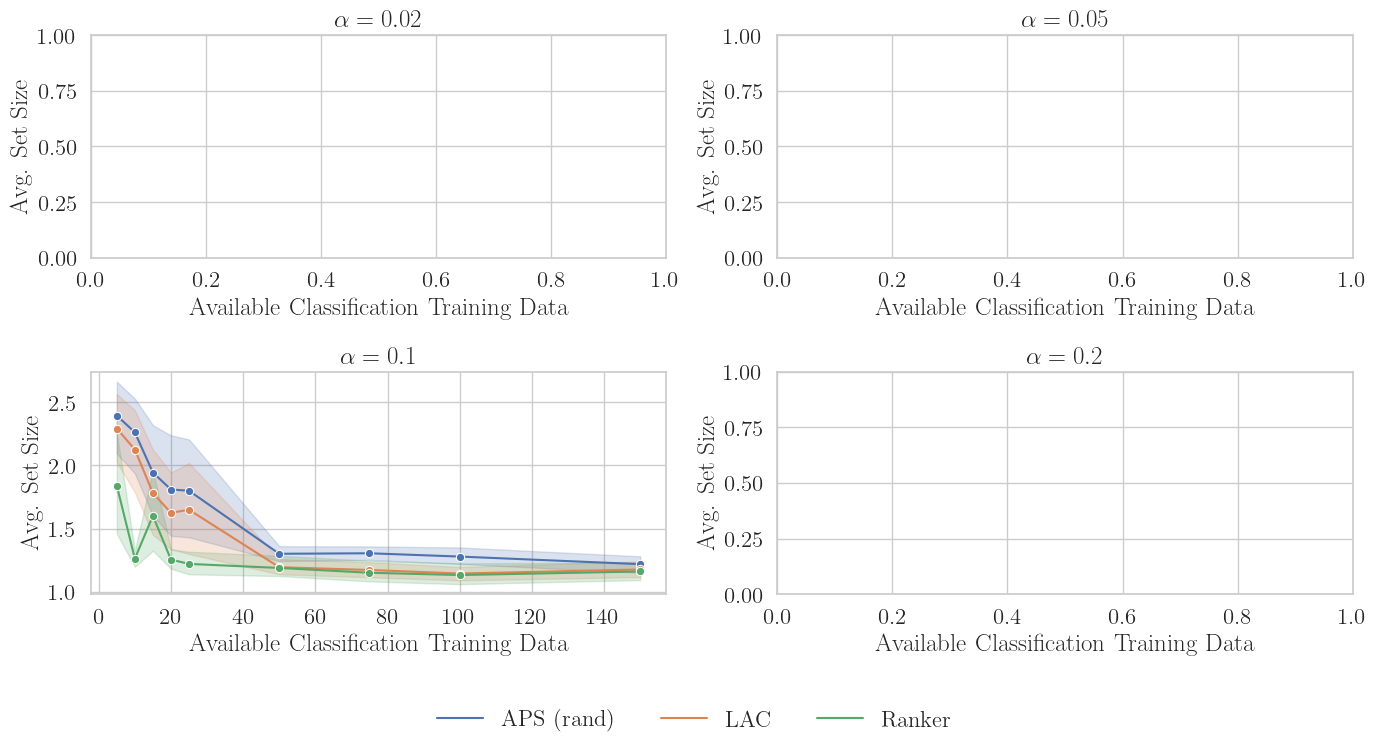

In [ ]:
import enum
import seaborn as sns
sns.set(font_scale=1.5,rc={'text.usetex' : True})
sns.set_style("whitegrid")
plt.rc('font', **{'family': 'serif'})
plt.rcParams["figure.figsize"] = (14, 7)
fig,axes = plt.subplots(2,2)
axes = axes.ravel()
for index, alpha in enumerate(alphas):
    ax = axes[index]
    alpha_df = result_df[result_df.alpha==alpha]
    sns.lineplot(ax=ax, data=alpha_df, hue="method" ,style="alpha", x="num_clf_data", y="avg_set_size", marker="o", legend=False)
    ax.set_xlabel("Available Classification Training Data")
    ax.set_ylabel("Avg. Set Size")
    ax.set_title(fr"$\alpha={alpha}$")


# Dummy plot (not shown) just to get handles/labels
dummy_ax = fig.add_subplot(111, frameon=False)  # invisible axis
dummy_ax.axis('off')  # hide it
dummy_plot = sns.lineplot(data=result_df, x='num_clf_data', y='avg_set_size', hue='method', ax=dummy_ax, legend='full')
handles, labels = dummy_ax.get_legend_handles_labels()
dummy_ax.remove()

label_map = {"rand_aps" : "APS (rand)","thr" : "LAC","ranker" : "Ranker",}

new_labels = [label_map.get(label, label) for label in labels]
lgd = fig.legend(handles, new_labels, loc='lower center', ncol=len(new_labels), bbox_to_anchor=(0.5, -0.1), frameon=False)
# for ax in axes:
#     ax.legend_.remove()

fig.tight_layout() 
plt.savefig("synthetic_clf_vs_ranker.pdf",bbox_extra_artists=(lgd,), bbox_inches='tight')
# plt.savefig("synthetic_clf_vs_ranker.pdf")

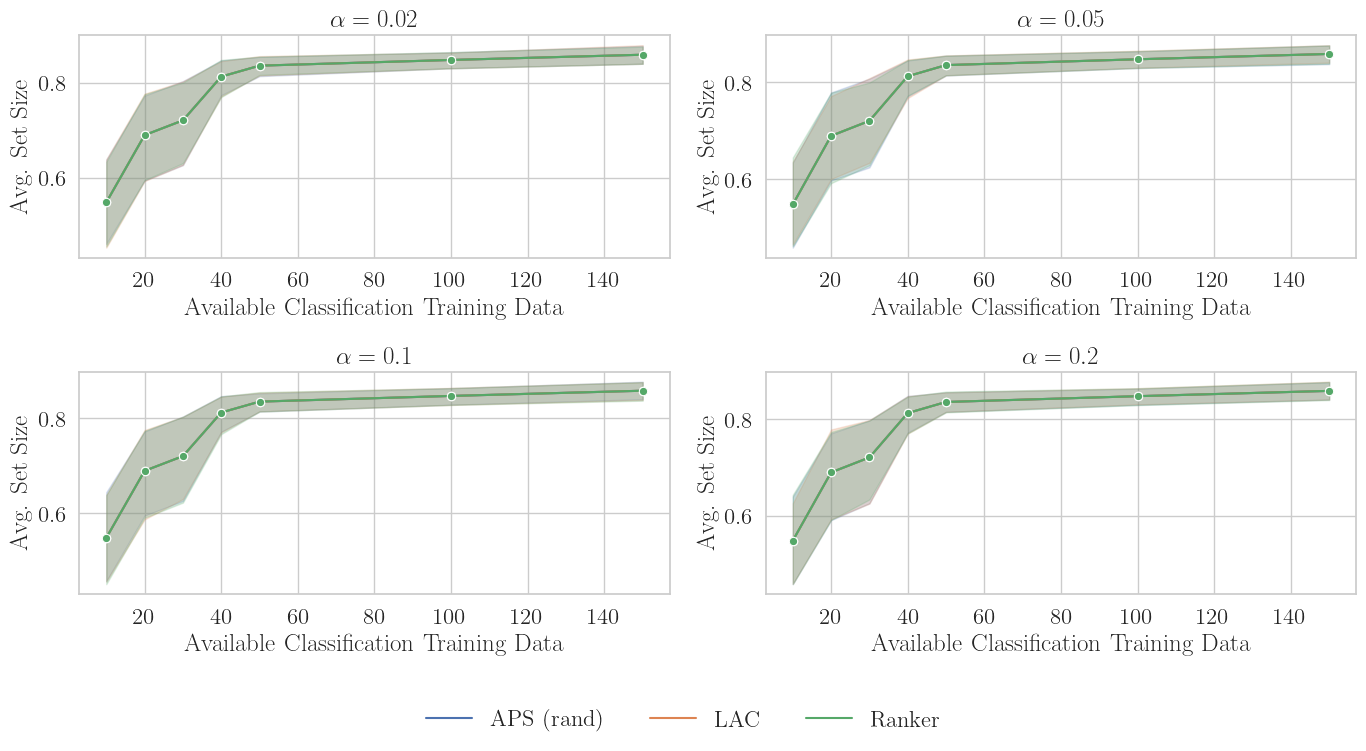

In [ ]:
import enum
import seaborn as sns
sns.set(font_scale=1.5,rc={'text.usetex' : True})
sns.set_style("whitegrid")
plt.rc('font', **{'family': 'serif'})
plt.rcParams["figure.figsize"] = (14, 7)
fig,axes = plt.subplots(2,2)
axes = axes.ravel()
for index, alpha in enumerate(alphas):
    ax = axes[index]
    alpha_df = result_df[result_df.alpha==alpha]
    sns.lineplot(ax=ax, data=alpha_df, hue="method" ,style="alpha", x="num_clf_data", y="accuracy", marker="o", legend=False)
    ax.set_xlabel("Available Classification Training Data")
    ax.set_ylabel("Avg. Set Size")
    ax.set_title(fr"$\alpha={alpha}$")


# Dummy plot (not shown) just to get handles/labels
dummy_ax = fig.add_subplot(111, frameon=False)  # invisible axis
dummy_ax.axis('off')  # hide it
dummy_plot = sns.lineplot(data=result_df, x='num_clf_data', y='accuracy', hue='method', ax=dummy_ax, legend='full')
handles, labels = dummy_ax.get_legend_handles_labels()
dummy_ax.remove()

label_map = {"rand_aps" : "APS (rand)","thr" : "LAC","ranker" : "Ranker",}

new_labels = [label_map.get(label, label) for label in labels]
fig.legend(handles, new_labels, loc='lower center', ncol=len(new_labels), bbox_to_anchor=(0.5, -0.1), frameon=False)
# for ax in axes:
#     ax.legend_.remove()

fig.tight_layout() 
# plt.savefig("replicating.pdf",bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.savefig("synthetic_clf_vs_ranker.pdf")

<Axes: xlabel='num_clf_data', ylabel='accuracy'>

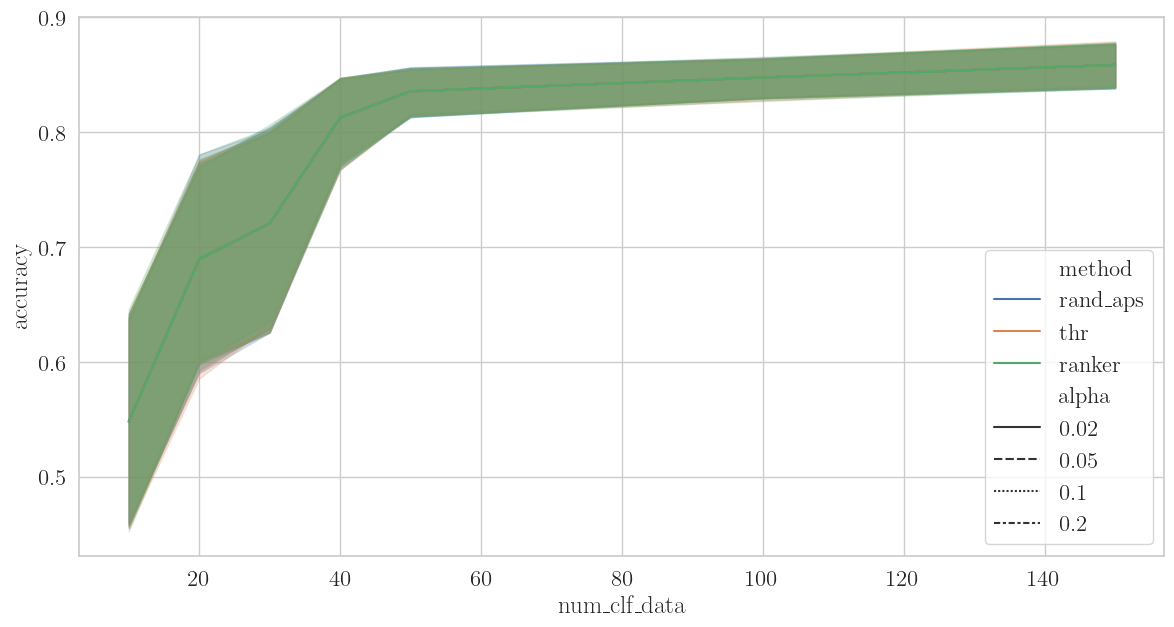

In [ ]:
sns.lineplot(data=result_df, hue="method" ,style="alpha", x="num_clf_data", y="accuracy")


In [ ]:
result_df

,seed,num_clf_data,alpha,method,avg_set_size,coverage_rate,accuracy
0,0,10,0.02,rand_aps,2.72,0.99,0.36
1,0,10,0.05,rand_aps,2.33,0.97,0.36
2,0,10,0.10,rand_aps,1.97,0.91,0.36
3,0,10,0.20,rand_aps,1.77,0.82,0.36
8,0,10,0.02,thr,2.60,0.99,0.36
...,...,...,...,...,...,...,...
2235,19,150,0.20,thr,0.93,0.84,0.88
2236,19,150,0.02,ranker,2.02,1.00,0.88
2237,19,150,0.05,ranker,1.51,0.99,0.88
2238,19,150,0.10,ranker,1.22,0.97,0.88
